# 1. NLP_Feature_Engineering Overview
tf-idf, LDA

In [154]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/andrewbennett/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrewbennett/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/andrewbennett/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [155]:
# Core libraries
import pandas as pd
import numpy as np
import re
from time import time
import spacy
import plotly.graph_objects as go

# NLTK for natural language processing
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer
from nltk.corpus import stopwords

# Matplotlib for plotting
from matplotlib import pyplot as plt

# Scikit-learn for machine learning and text processing
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, ConfusionMatrixDisplay, classification_report, roc_auc_score
from sklearn.pipeline import Pipeline

# Gensim for topic modeling
from gensim import corpora, models
from gensim.matutils import Sparse2Corpus
from gensim.models.coherencemodel import CoherenceModel


from xgboost import XGBClassifier
# SciPy for scientific computing
from scipy.sparse import csr_matrix

# TQDM for progress bars
from tqdm import tqdm
tqdm.pandas()

# Load Spacy English model
sp = spacy.load('en_core_web_sm')

# Define NLP tools and stop words set
porter = SnowballStemmer("english")
lmtzr = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


In [156]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

#!python -m spacy download en_core_web_sm
import spacy

import re
from collections import Counter

from tqdm import tqdm
tqdm.pandas()

from wordcloud import WordCloud

## 2. tf-idf, LDA

In [157]:
translated_news_save_path = "./downloads/tucapital-news_with_text-translated.csv"

# modify format
# Save the combined DataFrame to a CSV file
df_copy = pd.read_csv(translated_news_save_path)
df_copy.head()

,Unnamed: 0,title,url,date,text
0,0,"Tomorrow, last day of the account at 2.89% APR...",https://www.tucapital.es/depositos/manana-ulti...,23/04/2024,"Tomorrow, April 24, 2024, the marketing period..."
1,1,ING gives you up to €120 if you direct your pa...,https://www.tucapital.es/cuentas/ing-te-da-has...,22/04/2024,"ING now asks, in addition to direct debiting a..."
2,2,Banco BIG deposits: slight increase in normal ...,https://www.tucapital.es/depositos/depositos-d...,22/04/2024,Banco BIG remodels its deposit offer with slig...
3,3,The future of Bitcoin: predictions for the nex...,https://www.tucapital.es/blogs/guias/el-futuro...,22/04/2024,"Since its launch, Bitcoin has seen positive an..."
4,4,Eco: Cetelem only allows maximum daily transfe...,https://www.tucapital.es/blogs/eco/eco-cetelem...,19/04/2024,"Due to the disappearance of Orange Bank, and t..."


### 2. Feature Engineering Extraction

In [158]:
# Filter where Not-expected rows
date_pattern = re.compile(r'-\d{2}/\d{2}/\d{4}:')
df_cleaned = df_copy[~df_copy['title'].str.contains(date_pattern)]
# Drop nan
df_cleaned = df_cleaned.dropna(subset=['title', 'url', 'date'])

df_copy.shape, df_cleaned.shape

((1025, 5), (1018, 5))

In [159]:
df_cleaned['combined_text'] = (df_cleaned['title'] + ' ') * 3 + df_cleaned['text']

In [160]:
# Ensure 'combined_text' column is in the DataFrame
df_cleaned['combined_text'] = df_cleaned['combined_text'].astype(str)  # Convert to string in case it's not

# Count the number of words in each entry
df_cleaned['word_count'] = df_cleaned['combined_text'].apply(lambda x: len(x.split()))

# Verify the word counts
df_cleaned.head()

,Unnamed: 0,title,url,date,text,combined_text,word_count
0,0,"Tomorrow, last day of the account at 2.89% APR...",https://www.tucapital.es/depositos/manana-ulti...,23/04/2024,"Tomorrow, April 24, 2024, the marketing period...","Tomorrow, last day of the account at 2.89% APR...",318
1,1,ING gives you up to €120 if you direct your pa...,https://www.tucapital.es/cuentas/ing-te-da-has...,22/04/2024,"ING now asks, in addition to direct debiting a...",ING gives you up to €120 if you direct your pa...,400
2,2,Banco BIG deposits: slight increase in normal ...,https://www.tucapital.es/depositos/depositos-d...,22/04/2024,Banco BIG remodels its deposit offer with slig...,Banco BIG deposits: slight increase in normal ...,476
3,3,The future of Bitcoin: predictions for the nex...,https://www.tucapital.es/blogs/guias/el-futuro...,22/04/2024,"Since its launch, Bitcoin has seen positive an...",The future of Bitcoin: predictions for the nex...,656
4,4,Eco: Cetelem only allows maximum daily transfe...,https://www.tucapital.es/blogs/eco/eco-cetelem...,19/04/2024,"Due to the disappearance of Orange Bank, and t...",Eco: Cetelem only allows maximum daily transfe...,450


In [161]:
df_cleaned.shape

(1018, 7)

we want to find all of the banks so that we can remove them from the corpus 

In [162]:
# create one super large corpus 
corpus = ' '.join(df_cleaned['combined_text'].values)

# regex to find any word preceding 'bank'
pattern = re.compile(r'\b\w+\s+bank\b')

# find all matches
matches = pattern.findall(corpus.lower())

matches = set(matches)
matches


{'000 bank',
 '2 bank',
 '20 bank',
 'a bank',
 'active bank',
 'activo bank',
 'all bank',
 'and bank',
 'another bank',
 'any bank',
 'apr bank',
 'are bank',
 'arquia bank',
 'as bank',
 'auto bank',
 'bbva bank',
 'best bank',
 'bfs bank',
 'big bank',
 'blueorange bank',
 'bluor bank',
 'both bank',
 'caixa bank',
 'caminos bank',
 'central bank',
 'certain bank',
 'collaborating bank',
 'complete bank',
 'cooperative bank',
 'created bank',
 'custodian bank',
 'depositary bank',
 'deutsche bank',
 'digital bank',
 'each bank',
 'ebn bank',
 'either bank',
 'even bank',
 'federal bank',
 'first bank',
 'for bank',
 'foreign bank',
 'free bank',
 'french bank',
 'haitong bank',
 'her bank',
 'his bank',
 'imagin bank',
 'in bank',
 'international bank',
 'italian bank',
 'its bank',
 'know bank',
 'largest bank',
 'lea bank',
 'left bank',
 'main bank',
 'major bank',
 'mobile bank',
 'monitoring bank',
 'most bank',
 'neighborhood bank',
 'new bank',
 'nn bank',
 'no bank',
 'norw

In [163]:
additional_stop_words = ['arquia bank',
 'auto bank',
 'bbva bank',
 'blueorange bank',
 'bluor bank',
 'caixa bank',
 'caminos bank',
 'central bank',
 'deutsche bank',
 'digital bank',
 'ebn bank',
 'haitong bank',
 'imagin bank',
 'lea bank',
 'norwegian bank',
 'norweigan bank',
 'novum bank',
 'oragen bank',
 'orange bank',
 'portuguese bank',
 'raisin bank',
 'reanault bank',
 'reanult bank',
 'renalt bank',
 'renaul bank',
 'renault bank',
 'renaut bank',
 'renautl bank',
 'renualt bank',
 'revolut bank',
 'sme bank',
 'targo bank',
 'touch bank',
 'triodos bank', 
 'bank',
    "ing",
    "renault",
    "renault bank",
    "wizink",
    "sabadel",
    "myinvestor",
    "condit",
    "openbank",
    "bbva",
    "santand",
    "cetelem",
    "pibank",
    'sabadel',
    'sabadel bank',
    'santand',
    'santander',
    'sabadell',
    'orange',
    'banco'
]

#### TF-IDF

#### Tokenizer

In [164]:
# Ensure spaCy uses DataFrame efficiently
def spacy_lemmatize_series(text_series):
    # Disable unnecessary components to speed up processing
    
    disabled_components = sp.disable_pipes(["ner", "parser"])
    lemmatized_series = text_series.apply(lambda doc: " ".join([token.lemma_ for token in sp(doc)]))
    disabled_components.restore()
    return lemmatized_series

def preprocess_corpus(corpus_series):
    # Remove non-words, handle case, and remove stopwords in one pass
    stop_words = list(set(stopwords.words('english'))) + (additional_stop_words)
    processed_corpus = corpus_series.apply(lambda doc: " ".join([word.lower() if not re.match('([A-Z]+[a-z]*){2,}', word) else word for word in re.split(r'\W+', doc) if word.lower() not in stop_words]))
    return processed_corpus

def stem_series(corpus_series, stem_type='porter', language='english'):
    if stem_type == 'porter':
        stemmer = PorterStemmer()
    else:
        stemmer = SnowballStemmer(language)
    stemmed_series = corpus_series.apply(lambda doc: " ".join([stemmer.stem(word) for word in doc.split()]))
    return stemmed_series


In [165]:
df_cleaned['text_processed'] = spacy_lemmatize_series(df_cleaned['combined_text'])


In [166]:
# Assuming corpus_data is your DataFrame and TXT_EN is the text column
# preprocessing pipeline
df_cleaned['text_processed'] = preprocess_corpus(df_cleaned['text_processed'])


In [167]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(2, 4), max_df=0.7, min_df=0.0001)

# Fit and transform the cleaned text data
tfidf_features = tfidf_vectorizer.fit_transform(df_cleaned['text_processed'])

# Convert to dense matrix (if needed)
tfidf_features_dense = tfidf_features.toarray()

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

In [168]:
import numpy as np

# Sum tf-idf scores for each term
term_scores = np.sum(tfidf_features_dense, axis=0)

# Create a dictionary to store terms and their scores
term_score_dict = {term: score for term, score in zip(feature_names, term_scores)}

# Sort terms by their scores in descending order
sorted_terms = sorted(term_score_dict.items(), key=lambda x: x[1], reverse=True)


In [169]:
# print the top 10 terms

sorted_terms[:100]


[('12 month', 12.02747415914545),
 ('deposit apr', 9.821940515908528),
 ('account apr', 9.177434599875612),
 ('payroll account', 7.770899513613097),
 ('online account', 7.341779774972415),
 ('month deposit', 6.7718542557823636),
 ('month term', 6.389074687389756),
 ('new customer', 6.352133498822995),
 ('apr deposit', 6.316326601191504),
 ('interest rate', 6.119739688620454),
 ('offer deposit', 6.068176195039822),
 ('89 apr', 5.920472159656305),
 ('apr 12', 5.861723883504931),
 ('apr 12 month', 5.861723883504931),
 ('new client', 5.809429513501117),
 ('25 apr', 5.773465297058409),
 ('increase profitability', 5.710120238151569),
 ('account 89', 5.5839481023978),
 ('account 89 apr', 5.5839481023978),
 ('per month', 5.5348258817036395),
 ('without commission', 5.519976062824492),
 ('75 apr', 5.466013576920854),
 ('profitability deposit', 5.437505009744551),
 ('offer apr', 5.306783668198591),
 ('apr month', 5.24021635866527),
 ('saving account', 5.231537122123101),
 ('apr apr', 5.199209356

#### 'bank' related terms

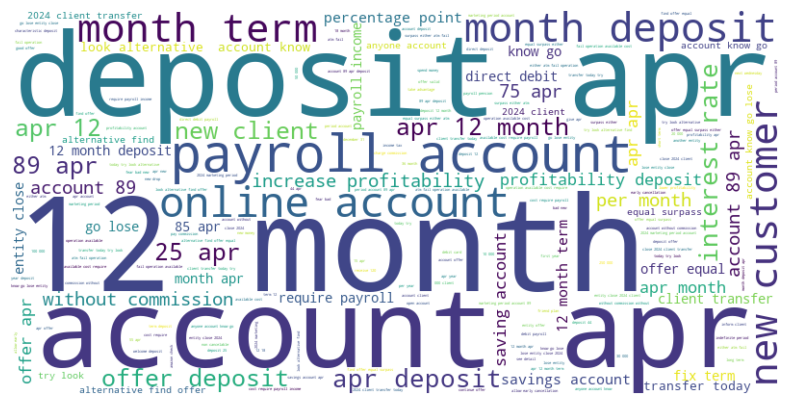

In [170]:
# Converting sorted_terms back to a dictionary
filtered_term_score_dict = dict(sorted_terms)
# Generate the word cloud
wordcloud = WordCloud(
    width = 800, 
    height = 400, 
    background_color = 'white'
).generate_from_frequencies(filtered_term_score_dict)

# Displaying the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')  # 'bilinear' for smoother appearance
plt.axis('off')  # No axis to be shown
plt.show()

### SVD Analysis

In [171]:
# implement svd with tfidf components 

# Initialize SVD
svd = TruncatedSVD(n_components=15, random_state=42)

# Fit and transform the tfidf features
svd_matrix = svd.fit_transform(tfidf_features)

# Check the shape of the SVD matrix
print(svd_matrix.shape)

# Create a DataFrame from the SVD matrix
svd_df = pd.DataFrame(svd_matrix, columns=[f"topic_{i}" for i in range(15)])

# get the top 10 terms for each component
def get_top_terms(components, feature_names, n_terms=10):
    top_terms = []
    for i, component in enumerate(components):
        top_terms_idx = np.argsort(component)[::-1][:n_terms]
        top_terms.append([(feature_names[idx], component[idx]) for idx in top_terms_idx])
    return top_terms

svd_df

(1018, 15)


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,0.121619,0.197586,0.482578,-0.067594,0.036941,-0.044507,-0.017292,-0.011084,-0.005220,-0.007107,-0.016867,-0.007014,0.002855,0.023276,-0.010844
1,0.205371,-0.106558,-0.023470,-0.042224,0.186689,0.045113,-0.049823,0.015539,-0.003104,0.030659,0.011322,-0.033737,0.016559,0.003534,0.012021
2,0.051446,0.018771,0.019188,0.034945,-0.034483,0.070415,0.004103,0.006895,0.017497,-0.022456,0.095030,0.074348,0.002374,-0.244379,0.222835
3,0.000719,-0.000088,0.000108,-0.000021,0.000019,0.000674,0.000204,-0.000369,-0.000070,0.000228,0.000356,0.000680,0.000305,-0.000093,0.001147
4,0.024368,-0.006581,-0.000245,0.001850,0.029952,0.026586,0.170297,-0.089800,-0.005446,0.022326,-0.015058,-0.004307,-0.001697,0.000922,0.000230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1013,0.081943,0.018224,0.004721,0.024636,-0.065830,0.072155,0.024677,0.014691,-0.011041,0.073708,0.038791,0.118343,0.016620,-0.224159,0.084336
1014,0.005393,-0.000349,0.000477,0.001877,-0.001410,0.003939,0.002798,-0.000025,0.002113,-0.002414,0.000318,0.002831,-0.000091,0.000577,-0.000849
1015,0.044691,0.013280,0.010493,0.019182,-0.030543,0.055732,0.007519,0.000877,0.012252,-0.015923,0.065062,0.053420,-0.000186,-0.177841,0.158100
1016,0.017296,-0.005777,-0.001294,-0.001558,0.010804,0.001259,0.002622,-0.000480,0.003681,-0.010886,-0.004204,0.011237,0.006614,-0.000285,0.010291


In [172]:
# add the topic terms to the dataframe
top_terms = get_top_terms(svd.components_, feature_names)

#print topics 
for i, terms in enumerate(top_terms):
    all_terms = []
    for term, score in terms:
        all_terms.append(term)
        
    print(all_terms)

['12 month', 'payroll account', 'deposit apr', 'account apr', 'online account', 'require payroll', 'go lose', 'know go', 'look alternative', 'transfer today']
['fear bad', 'fear bad new', 'new drop', 'bad new', '89 apr', 'account 89', 'account 89 apr', 'amazon check', 'apr deposit', 'amazon es']
['account 89', 'account 89 apr', '89 apr', '44 apr', 'account 89 apr deposit', '89 apr deposit', 'apr deposit', 'deposit 44', 'period account 89', 'marketing period account 89']
['24 36 month', '18 24 36', '18 24 36 month', '24 36', '18 24', '36 month', '12 18 24 36', 'choose 12 18 24', '12 18 24', 'choose 12 18']
['payroll account', 'receive 120', 'spend money', '250 000', '000 client', 'debit card want', 'series supermarket indicate receive', 'payroll spend money debit', '120 welcome give bonus', '120 welcome give']
['non cancelable', 'profitability deposit', 'bfs cut', 'fix term', 'apr 12', 'apr 12 month', '12 month', 'cancelable deposit', 'percentage point', '75 apr']
['june 17', 'june 17 2

In [177]:
# conduct topic modeling with LDA 
# Initialize LDA
lda = LatentDirichletAllocation(n_components=15, random_state=42)

# Fit and transform the tfidf features
lda_matrix = lda.fit_transform(tfidf_features)

# Check the shape of the LDA matrix
print(lda_matrix.shape)

# Create a DataFrame from the LDA matrix
lda_df = pd.DataFrame(lda_matrix, columns=[f"topic_{i}" for i in range(15)])

# get the top 10 terms for each component
lda_top_terms = get_top_terms(lda.components_, feature_names)

#print topics
for i, terms in enumerate(lda_top_terms):
    all_terms = []
    for term, score in terms:
        all_terms.append(term)
        
    print(all_terms)

(1018, 15)
['welcome deposit', '25 apr', 'apr big', 'lower profitability', 'deposit 25', 'welcome deposit 25 apr', 'welcome deposit 25', 'deposit 25 apr', 'lower profitability deposit', '25 apr apr']
['12 month deposit', 'payroll account', 'immediate transfer', 'february 14', 'deposit 34 apr', 'use bizum', '34 apr', 'deposit 34', '24 percentage point', '24 percentage']
['welcome amazon', 'welcome amazon check', '60 welcome amazon', 'check cashback', '60 welcome amazon check', 'welcome amazon check cashback', 'amazon check cashback', '60 welcome', 'amazon check cashback 72', 'check cashback 72']
['receive 120', 'spend money', '250 000', 'payroll account', 'direct deposit', 'deposit income', 'direct deposit income', 'direct deposit income addition', 'deposit income addition', 'income addition']
['85 apr', '15 apr', 'apr offer', '12 month', 'exclusive deposit', 'balance increase', 'month term', 'offer exclusive deposit', 'offer exclusive', 'another entity']
['online casino', 'without comm

In [180]:
lda_df

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,top_topic_lda
0,0.003716,0.003716,0.003716,0.003716,0.552119,0.003716,0.003716,0.003716,0.003716,0.003716,0.399571,0.003716,0.003716,0.003716,0.003716,4
1,0.003469,0.625954,0.003467,0.328954,0.003476,0.003467,0.003467,0.003468,0.003468,0.003467,0.003469,0.003467,0.003467,0.003471,0.003468,1
2,0.959571,0.002889,0.002887,0.002887,0.002887,0.002887,0.002887,0.002887,0.002887,0.002888,0.002888,0.002887,0.002887,0.002893,0.002887,0
3,0.002043,0.002043,0.080127,0.002043,0.893311,0.002044,0.002043,0.002043,0.002043,0.002043,0.002043,0.002043,0.002043,0.002043,0.002043,4
4,0.003001,0.003001,0.003001,0.003001,0.003001,0.003001,0.003001,0.003001,0.003001,0.003001,0.842398,0.003001,0.003001,0.003001,0.118590,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1013,0.003137,0.003137,0.003137,0.003137,0.003137,0.003137,0.003137,0.003137,0.003137,0.003137,0.003137,0.003137,0.003137,0.003137,0.956085,14
1014,0.227362,0.002592,0.002592,0.738941,0.002592,0.002592,0.002592,0.002592,0.002592,0.002592,0.002592,0.002592,0.002592,0.002595,0.002593,3
1015,0.222760,0.002923,0.002922,0.002922,0.002922,0.002922,0.002922,0.739234,0.002922,0.002933,0.002925,0.002922,0.002922,0.002923,0.002925,7
1016,0.002333,0.159580,0.002333,0.024102,0.002333,0.002332,0.788326,0.002332,0.002333,0.002332,0.002333,0.002332,0.002332,0.002332,0.002333,6


In [181]:
# put the top topic for each article in df_cleaned

# Get the index of the highest value in each row
df_cleaned['top_topic'] = lda_df.top_topic_lda

# to csv
df_cleaned.to_csv("downloads/tucapital_lda_topics.csv", index=False)

### when we remove stop words and do stemming, importance of emojs in each topics is decreased and less than words. But, after removing stop words and do stemming, tokens in each topics give a better explanation

In [39]:
# Using get_document_topics with an explicit minimum_probability
doc_topics_mod1 = [lda_model_mod1_topics_5.get_document_topics(item, minimum_probability=0.0000001) for item in corpus_mod1]

#note you could also use this vector = [lda[item] for item in corpus] but this has a higher threshold. 
#I like my topic vectors complete!

#this produces a lits of tuples
print(doc_topics_mod1[0])

[(0, 0.0010776268), (1, 0.0010772613), (2, 0.0010764663), (3, 0.0010773231), (4, 0.9946129), (5, 0.0010784998)]


In [40]:
topics_mod1 = lda_model_mod1_topics_5.show_topics(num_topics=-1, num_words=50, formatted=False)
topics_mod1

[(0,
  [('apr', 0.028774412),
   ('account', 0.022777848),
   ('bank', 0.022084104),
   ('deposits', 0.015625391),
   ('profitability', 0.011114139),
   ('offer', 0.010950641),
   ('month', 0.009142956),
   ('offers', 0.008960028),
   ('payroll', 0.008613193),
   ('see', 0.008029604),
   ('clients', 0.0077568563),
   ('interest', 0.0073127835),
   ('deposit', 0.0071143527),
   ('term', 0.0070851385),
   ('new', 0.0068191355),
   ('entity', 0.0066377646),
   ('months', 0.006598839),
   ('banco', 0.0065661813),
   ('year', 0.0055732545),
   ('money', 0.00493856),
   ('maximum', 0.0049356716),
   ('days', 0.0046978956),
   ('also', 0.0046759397),
   ('without', 0.004136548),
   ('first', 0.0040172026),
   ('products', 0.0039817668),
   ('time', 0.003879777),
   ('banks', 0.0038623267),
   ('commissions', 0.0037106075),
   ('myinvestor', 0.003458579),
   ('years', 0.0034277805),
   ('orange', 0.0033436762),
   ('online', 0.0033158597),
   ('income', 0.0033133035),
   ('period', 0.003230976

               0          1          2          3          4          5
2024   57.975093  39.561913   8.608926   6.001238  15.137741   3.715089
2023  166.372418  65.945495  25.356680  33.387531  21.171059  11.766818
2022   89.564816  68.499226  21.317783  35.534348  23.791930  15.291898
2021   65.443929  60.946814  50.462635  43.465682  75.744584   9.936357
2020    1.248245   0.039224   0.155975   0.555267   0.999131   0.002158


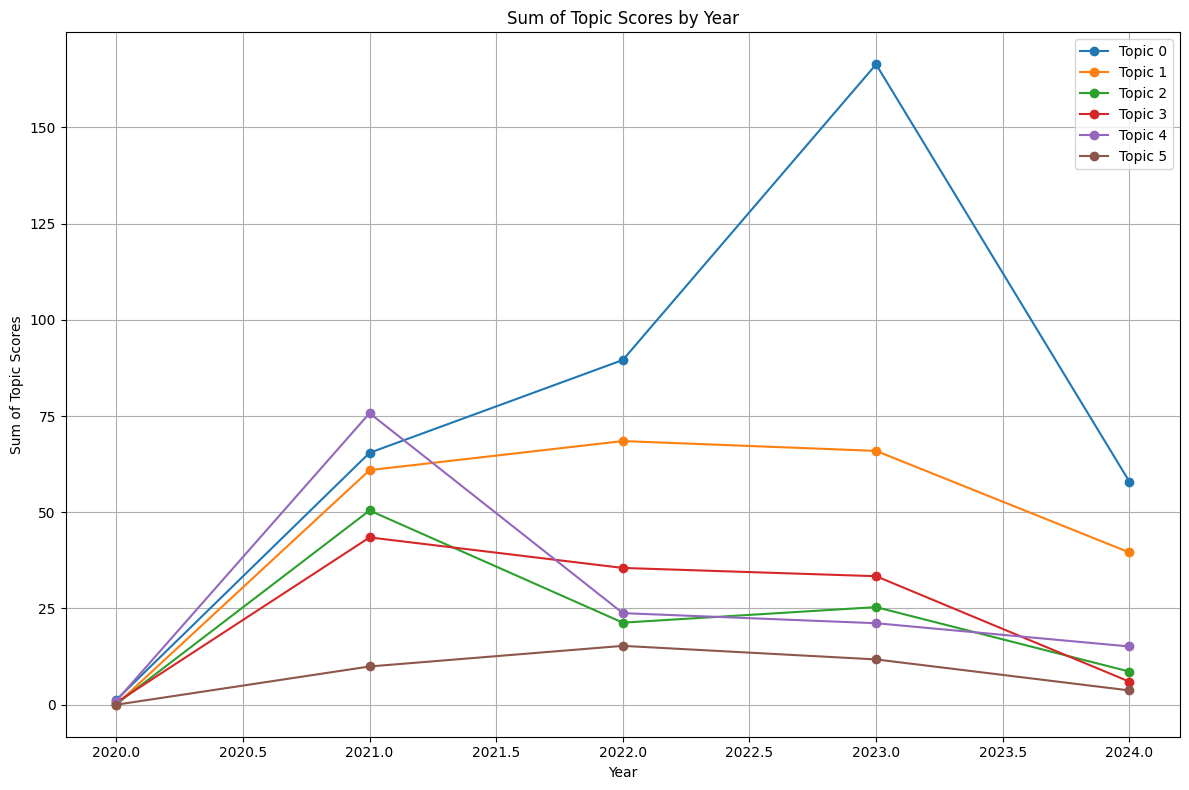

In [41]:
from collections import defaultdict
# Add a column for the year
df_copy['year'] = df_copy['date'].dt.year

# Initialize a dictionary to hold the sum of topic scores for each year
topic_scores_by_year = defaultdict(lambda: defaultdict(float))

# Sum the topic scores for each document by year
for i, doc in enumerate(doc_topics):
    year = df_copy.iloc[i]['year']
    for topic, score in doc:
        topic_scores_by_year[year][topic] += score

# Convert the dictionary to a DataFrame for easier analysis and visualization
topic_scores_df = pd.DataFrame(topic_scores_by_year).T

# Print the topic scores by year
print(topic_scores_df)

# Plot the topic scores by year
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for topic in topic_scores_df.columns:
    plt.plot(topic_scores_df.index, topic_scores_df[topic], marker='o', label=f'Topic {topic}')

plt.title('Sum of Topic Scores by Year')
plt.xlabel('Year')
plt.ylabel('Sum of Topic Scores')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
df_copy['topic_scores'] = doc_topics

'''
# Display the topic scores for each article
for index, row in df_copy.iterrows():
    print(f"Article {index + 1}: {row['title']}")
    for topic, score in row['topic_scores']:
        print(f"    Topic {topic}: {score}")'''

'\n# Display the topic scores for each article\nfor index, row in df_copy.iterrows():\n    print(f"Article {index + 1}: {row[\'title\']}")\n    for topic, score in row[\'topic_scores\']:\n        print(f"    Topic {topic}: {score}")'

In [43]:
# Determine the dominant topic for each article and store it in a new column
df_copy['dominant_topic'] = df_copy['topic_scores'].apply(lambda topics: max(topics, key=lambda x: x[1])[0])

# Display the topic scores and dominant topic for each article
for index, row in df_copy.iterrows():
    print(f"Article {index + 1}: {row['title']}")
    for topic, score in row['topic_scores']:
        print(f"    Topic {topic}: {score}")
    print(f"    Dominant Topic: {row['dominant_topic']}")

# Print the DataFrame with the dominant topic for each article
print(df_copy[['title', 'dominant_topic']])

Article 1: Tomorrow, last day of the account at 2.89% APR and deposit at 3.44% APR from Renault Bank
    Topic 0: 0.12626715004444122
    Topic 1: 0.0010801240568980575
    Topic 2: 0.001077739056199789
    Topic 3: 0.0010786433704197407
    Topic 4: 0.8694197535514832
    Topic 5: 0.001076571992598474
    Dominant Topic: 4
Article 2: ING gives you up to €120 if you direct your payroll and pay with their card
    Topic 0: 0.04748564586043358
    Topic 1: 0.9425119757652283
    Topic 2: 0.0010019942419603467
    Topic 3: 0.001003099256195128
    Topic 4: 0.006996943615376949
    Topic 5: 0.0010003277566283941
    Dominant Topic: 1
Article 3: Banco BIG deposits: slight increase in normal and combined deposits 5.06% APR
    Topic 0: 0.9964971542358398
    Topic 1: 0.0007009481778368354
    Topic 2: 0.0007003473583608866
    Topic 3: 0.0007007913663983345
    Topic 4: 0.0007006186642684042
    Topic 5: 0.0007001328049227595
    Dominant Topic: 0
Article 4: The future of Bitcoin: prediction

                 0          1          2         3          4         5
2024-04   8.646887  11.748401   2.076855  0.751315   4.043099  1.733443
2024-03   7.977824   8.164131   2.559730  3.857079   5.263551  0.177684
2024-02  22.655673   9.989678   3.433644  0.535299   2.688225  1.697480
2024-01  18.694709   9.659702   0.538697  0.857544   3.142866  0.106482
2023-12  10.703631   5.466461   2.075637  1.509598   1.283683  1.960991
2023-11  13.985089  11.692371   2.414006  5.554003   1.846302  0.508229
2023-10  16.473666   7.127068   2.244663  4.690007   1.793034  2.671562
2023-09  16.871416   4.489072   2.281946  3.427034   3.244147  1.686385
2023-08  11.226276   3.591231   2.590418  3.173888   1.115574  0.302614
2023-07   9.110154   5.412571   2.273797  2.142919   0.966365  0.094194
2023-06  13.535095   3.376538   2.252652  1.572727   1.248760  2.014228
2023-05  22.008329   3.566604   1.404387  5.730041   1.953433  0.337206
2023-04  11.503356   2.454650   1.393137  2.204284   1.591961  0

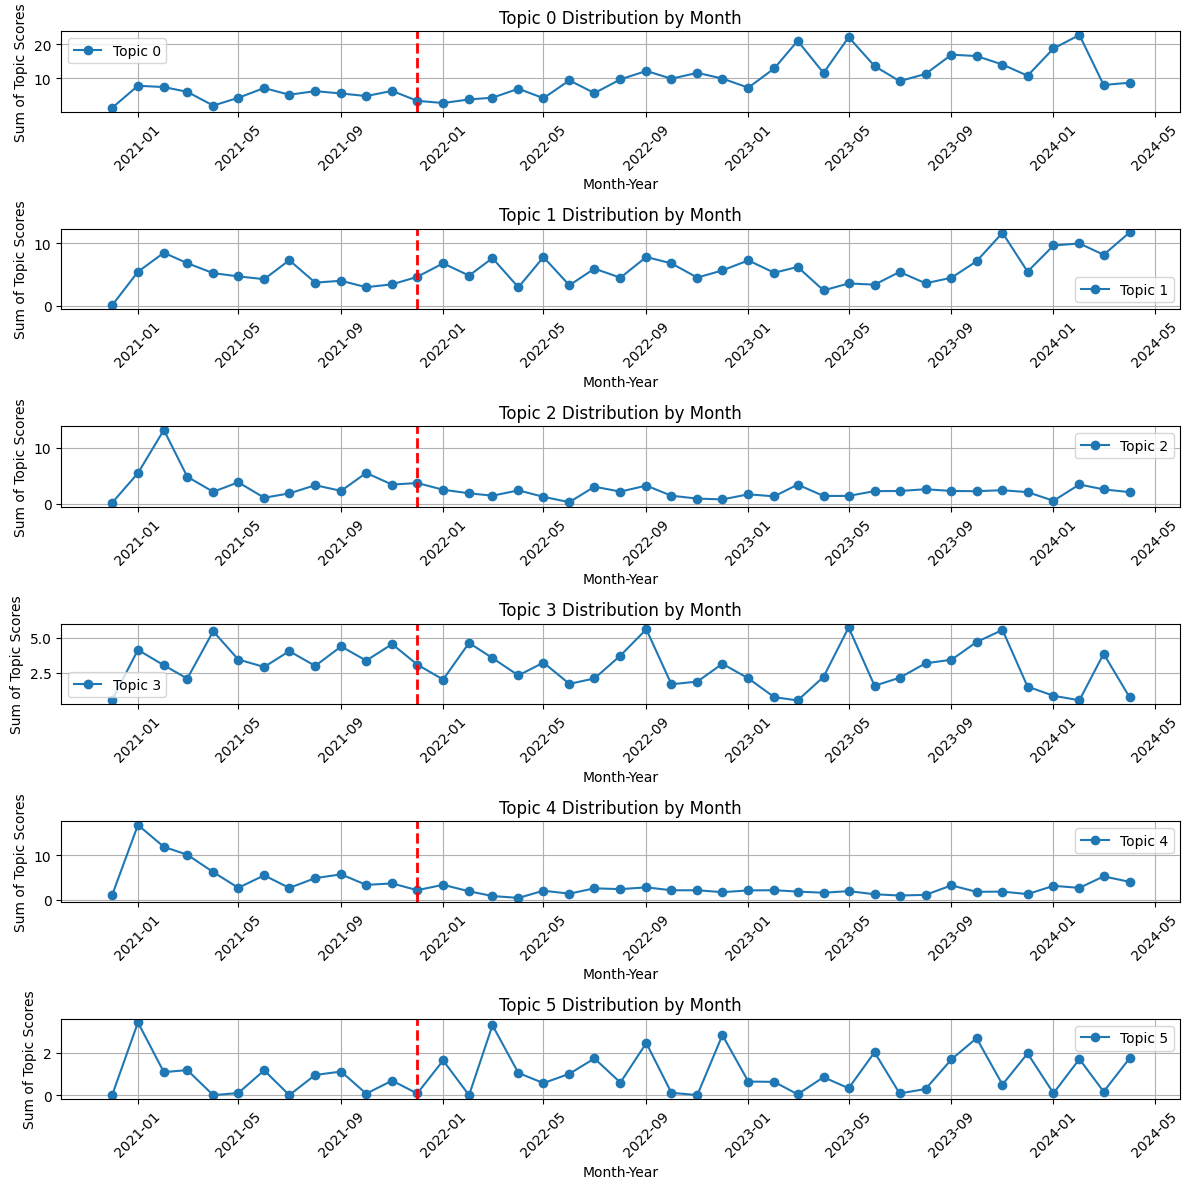

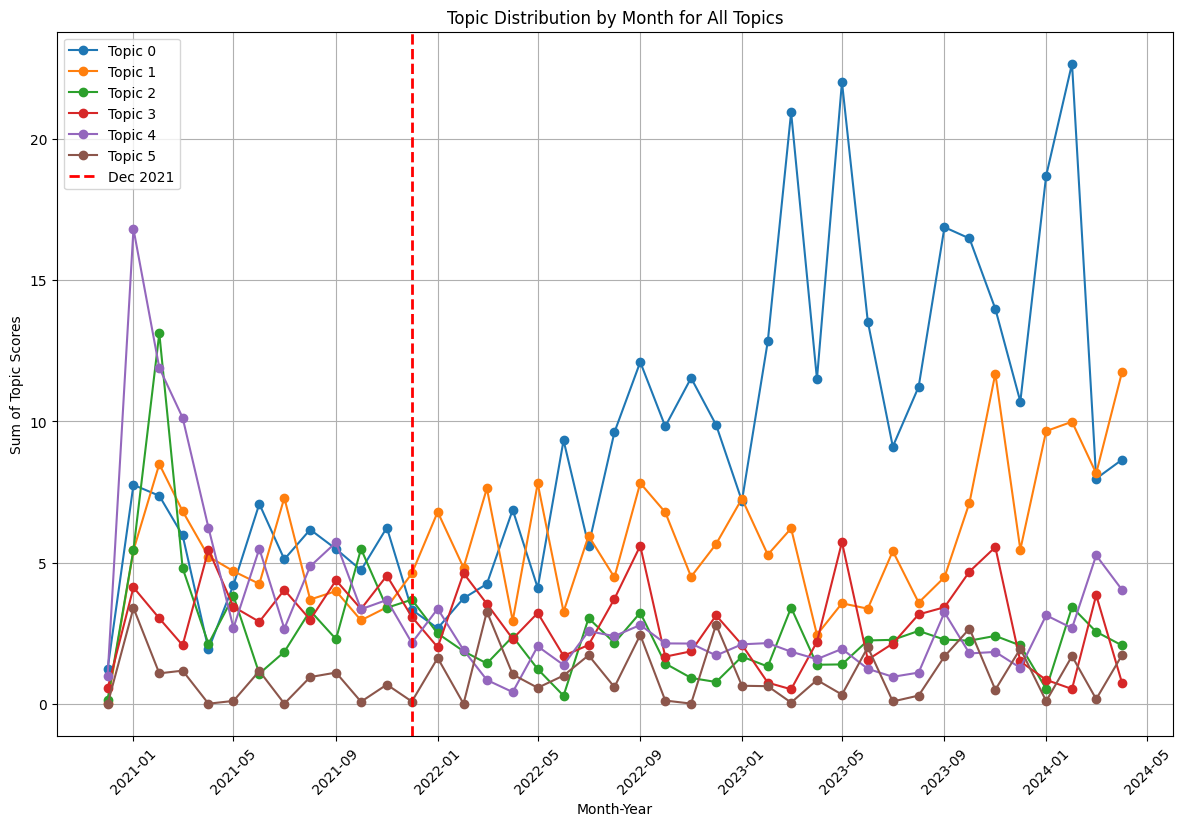

In [44]:
from collections import defaultdict

# Ensure date is in datetime format
df_copy['date'] = pd.to_datetime(df_copy['date'])

# Convert date to month-year format
df_copy['month_year'] = df_copy['date'].dt.to_period('M')

# Initialize a dictionary to hold the sum of topic scores for each month-year
topic_scores_by_month = defaultdict(lambda: defaultdict(float))

# Sum the topic scores for each document by month-year
for i, doc in enumerate(doc_topics):
    month_year = df_copy.iloc[i]['month_year']
    for topic, score in doc:
        topic_scores_by_month[month_year][topic] += score

# Convert the dictionary to a DataFrame for easier analysis and visualization
topic_scores_month_df = pd.DataFrame(topic_scores_by_month).T

# Print the topic scores by month-year
print(topic_scores_month_df)

# Plot the topic scores by month-year for each topic
fig, axs = plt.subplots(len(topic_scores_month_df.columns), 1, figsize=(12, 2 * len(topic_scores_month_df.columns)), tight_layout=True)

for i, topic in enumerate(topic_scores_month_df.columns):
    axs[i].plot(topic_scores_month_df.index.to_timestamp(), topic_scores_month_df[topic], marker='o', label=f'Topic {topic}')
    axs[i].set_title(f'Topic {topic} Distribution by Month')
    axs[i].set_xlabel('Month-Year')
    axs[i].set_ylabel('Sum of Topic Scores')
    axs[i].legend()
    axs[i].grid(True)
    axs[i].axvline(pd.Timestamp('2021-12-01'), color='red', linestyle='--', linewidth=2, label='Dec 2021')
    axs[i].xaxis.set_tick_params(rotation=45)

# Show the individual plots
plt.show()

# Plot all topics together in one plot
plt.figure(figsize=(12, 8))
for topic in topic_scores_month_df.columns:
    plt.plot(topic_scores_month_df.index.to_timestamp(), topic_scores_month_df[topic], marker='o', label=f'Topic {topic}')

plt.axvline(pd.Timestamp('2021-12-01'), color='red', linestyle='--', linewidth=2, label='Dec 2021')

plt.title('Topic Distribution by Month for All Topics')
plt.xlabel('Month-Year')
plt.ylabel('Sum of Topic Scores')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

            4     1     0    5     2    3
2024-04   5.0  12.0   8.0  2.0   2.0  NaN
2024-03   6.0   8.0   6.0  NaN   3.0  5.0
2024-02   2.0  11.0  23.0  1.0   4.0  NaN
2024-01   3.0  12.0  18.0  NaN   NaN  NaN
2023-12   2.0   6.0   9.0  3.0   2.0  1.0
2023-11   1.0  13.0  14.0  NaN   2.0  6.0
2023-10   2.0   8.0  15.0  3.0   2.0  5.0
2023-09   4.0   4.0  17.0  1.0   3.0  3.0
2023-08   2.0   4.0  11.0  NaN   3.0  2.0
2023-07   NaN   7.0   9.0  NaN   2.0  2.0
2023-06   NaN   4.0  15.0  2.0   2.0  1.0
2023-05   2.0   2.0  22.0  NaN   2.0  7.0
2023-04   1.0   3.0  12.0  1.0   1.0  2.0
2023-03   3.0   7.0  20.0  NaN   3.0  NaN
2023-02   3.0   6.0  12.0  NaN   2.0  NaN
2023-01   3.0   8.0   5.0  NaN   2.0  3.0
2022-12   2.0   6.0   9.0  3.0   1.0  3.0
2022-11   3.0   4.0  10.0  NaN   1.0  3.0
2022-10   3.0   7.0   9.0  NaN   1.0  2.0
2022-09   2.0  11.0  11.0  3.0   3.0  4.0
2022-08   3.0   5.0  11.0  1.0   1.0  2.0
2022-07   2.0   8.0   5.0  2.0   2.0  2.0
2022-06   1.0   4.0  10.0  1.0   N

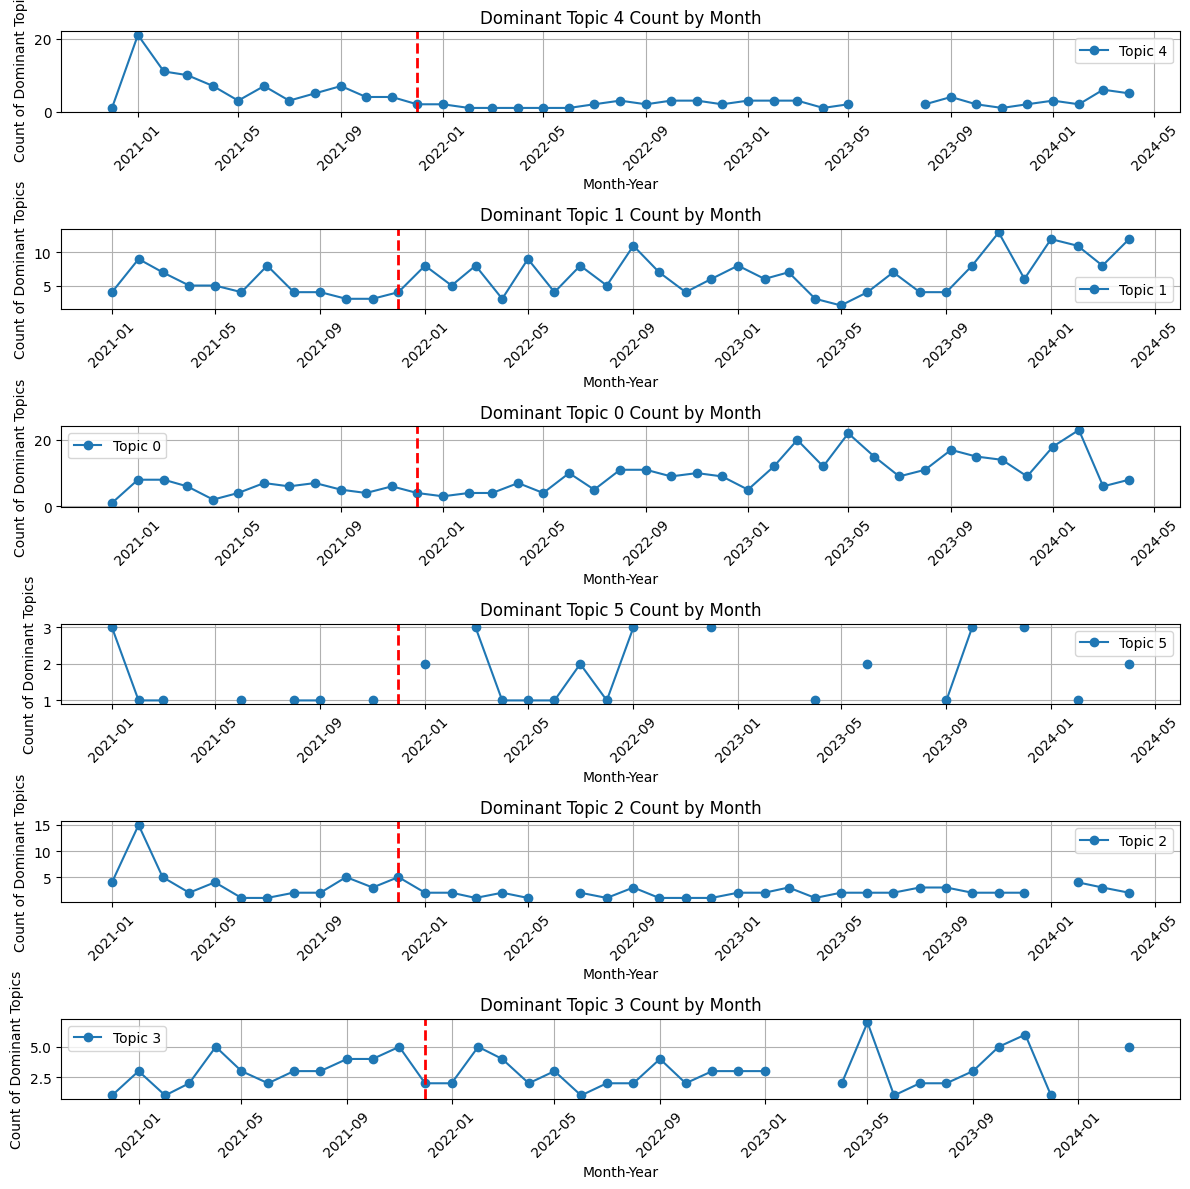

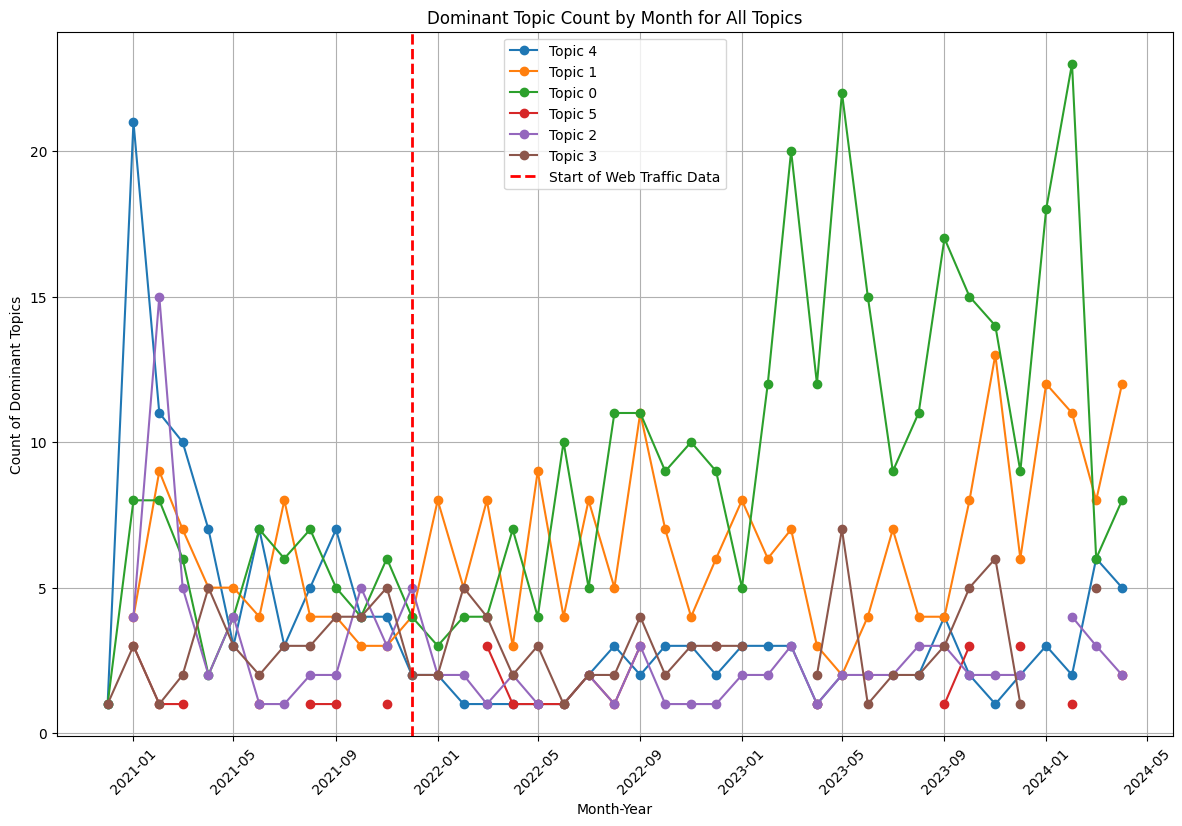

In [45]:
from collections import defaultdict

# Ensure date is in datetime format
df_copy['date'] = pd.to_datetime(df_copy['date'])

# Convert date to month-year format
df_copy['month_year'] = df_copy['date'].dt.to_period('M')

# Determine the dominant topic for each article and store it in a new column
df_copy['dominant_topic'] = df_copy['topic_scores'].apply(lambda topics: max(topics, key=lambda x: x[1])[0])

# Initialize a dictionary to hold the count of dominant topics for each month-year
dominant_topic_counts_by_month = defaultdict(lambda: defaultdict(int))

# Count the dominant topics for each document by month-year
for i, row in df_copy.iterrows():
    month_year = row['month_year']
    dominant_topic = row['dominant_topic']
    dominant_topic_counts_by_month[month_year][dominant_topic] += 1

# Convert the dictionary to a DataFrame for easier analysis and visualization
dominant_topic_counts_month_df = pd.DataFrame(dominant_topic_counts_by_month).T

# Print the dominant topic counts by month-year
print(dominant_topic_counts_month_df)

# Plot the dominant topic counts by month-year for each topic
fig, axs = plt.subplots(len(dominant_topic_counts_month_df.columns), 1, figsize=(12, 2 * len(dominant_topic_counts_month_df.columns)), tight_layout=True)

for i, topic in enumerate(dominant_topic_counts_month_df.columns):
    axs[i].plot(dominant_topic_counts_month_df.index.to_timestamp(), dominant_topic_counts_month_df[topic], marker='o', label=f'Topic {topic}')
    axs[i].set_title(f'Dominant Topic {topic} Count by Month')
    axs[i].set_xlabel('Month-Year')
    axs[i].set_ylabel('Count of Dominant Topics')
    axs[i].legend()
    axs[i].grid(True)
    axs[i].axvline(x=pd.Timestamp('2021-12-01'), color='red', linestyle='--', linewidth=2, label='Start of Web Traffic Data')
    axs[i].xaxis.set_tick_params(rotation=45)

# Show the individual plots
plt.show()

# Plot all dominant topics together in one plot
plt.figure(figsize=(12, 8))
for topic in dominant_topic_counts_month_df.columns:
    plt.plot(dominant_topic_counts_month_df.index.to_timestamp(), dominant_topic_counts_month_df[topic], marker='o', label=f'Topic {topic}')

plt.axvline(x=pd.Timestamp('2021-12-01'), color='red', linestyle='--', linewidth=2, label='Start of Web Traffic Data')
plt.title('Dominant Topic Count by Month for All Topics')
plt.xlabel('Month-Year')
plt.ylabel('Count of Dominant Topics')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

               0          1          2          3          4          5
2024   57.975093  39.561913   8.608926   6.001238  15.137741   3.715089
2023  166.372418  65.945495  25.356680  33.387531  21.171059  11.766818
2022   89.564816  68.499226  21.317783  35.534348  23.791930  15.291898
2021   65.443929  60.946814  50.462635  43.465682  75.744584   9.936357
2020    1.248245   0.039224   0.155975   0.555267   0.999131   0.002158


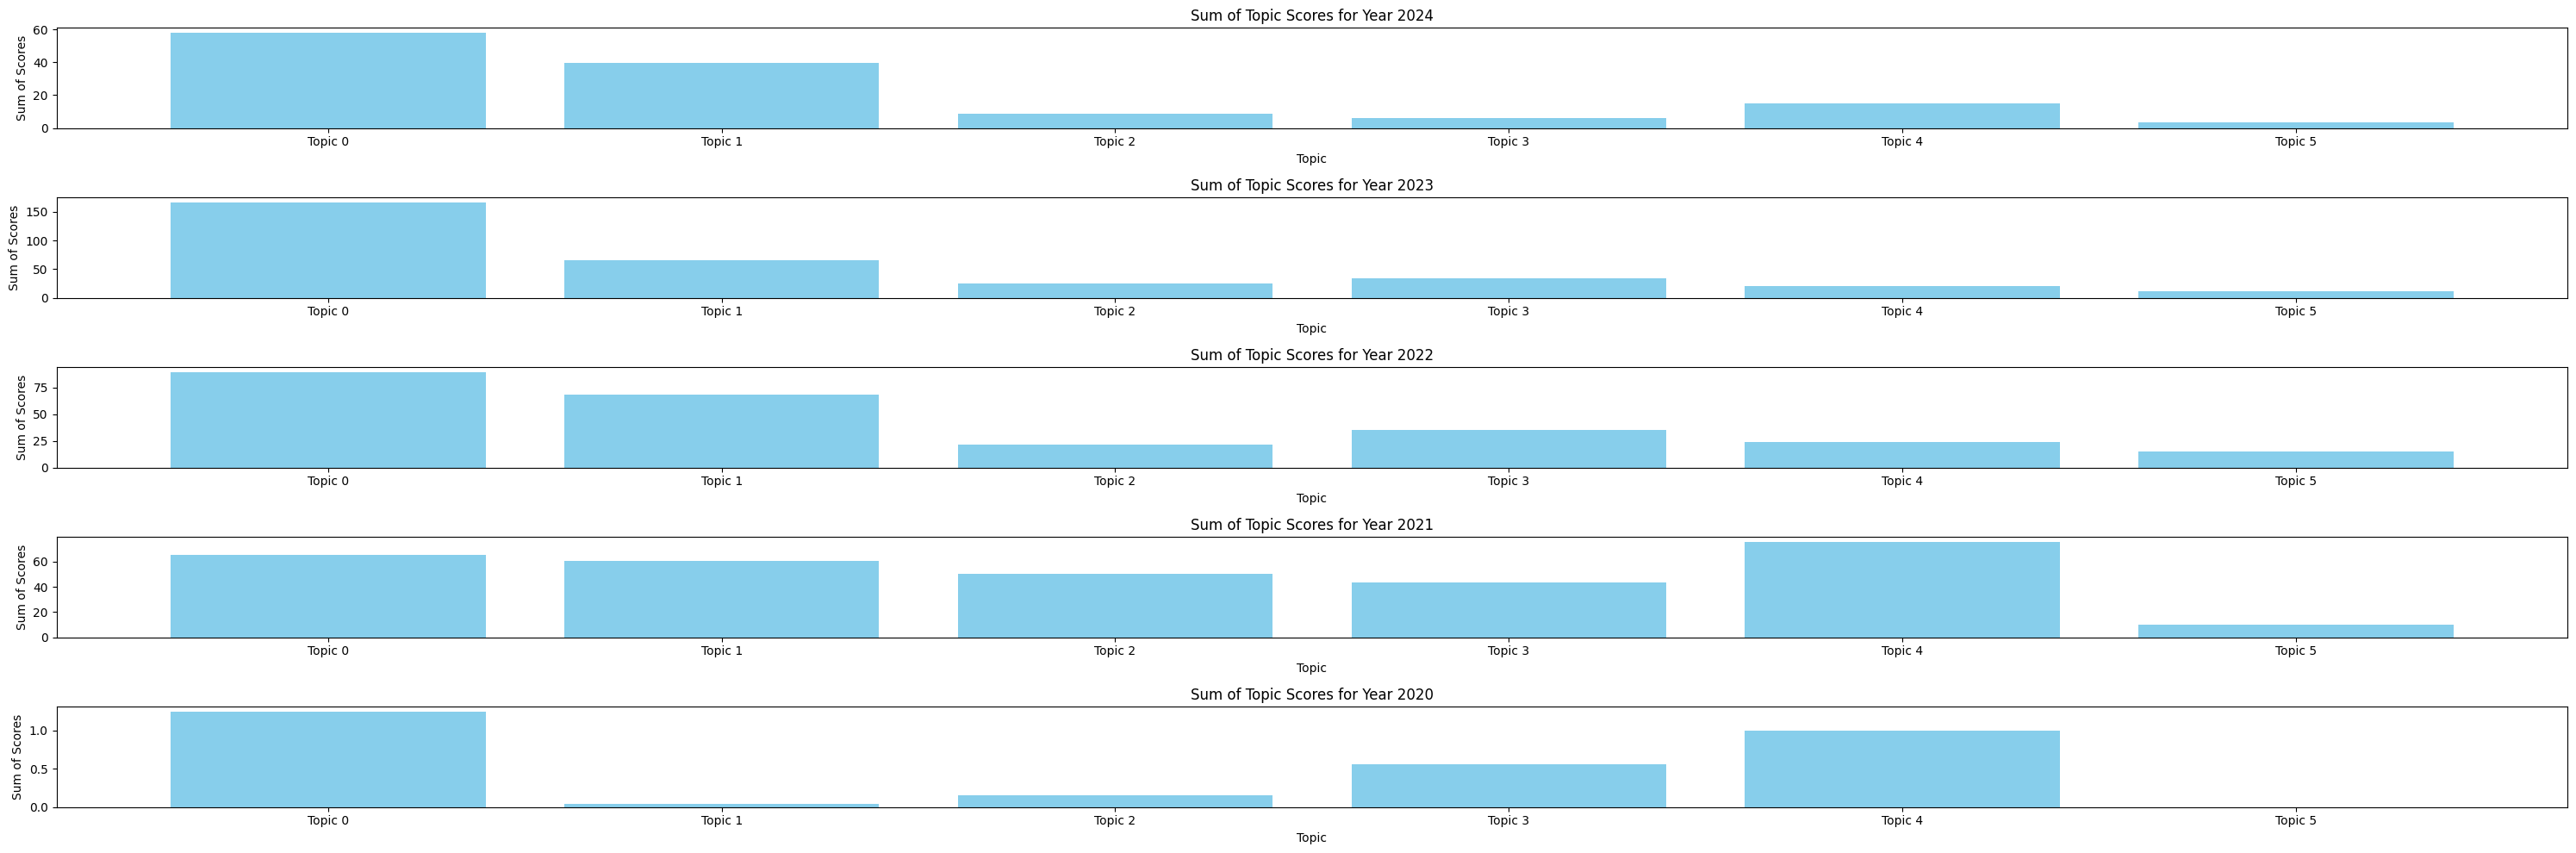

In [46]:
# Add a column for the year
df_copy['year'] = df_copy['date'].dt.year

# Initialize a dictionary to hold the sum of topic scores for each year
topic_scores_by_year = defaultdict(lambda: defaultdict(float))

# Sum the topic scores for each document by year
for i, doc in enumerate(doc_topics):
    year = df_copy.iloc[i]['year']
    for topic, score in doc:
        topic_scores_by_year[year][topic] += score

# Convert the dictionary to a DataFrame for easier analysis and visualization
topic_scores_df = pd.DataFrame(topic_scores_by_year).T

# Print the topic scores by year
print(topic_scores_df)

# Plot the topic scores by year using bar plots
years = topic_scores_df.index
num_topics = len(topic_scores_df.columns)

plt.figure(figsize=(30, 10))

for i, year in enumerate(years):
    plt.subplot(len(years), 1, i + 1)
    plt.bar(range(num_topics), topic_scores_df.loc[year], color='skyblue')
    plt.title(f'Sum of Topic Scores for Year {year}')
    plt.xlabel('Topic')
    plt.ylabel('Sum of Scores')
    plt.xticks(range(num_topics), [f'Topic {j}' for j in range(num_topics)])
    plt.tight_layout()

plt.show()

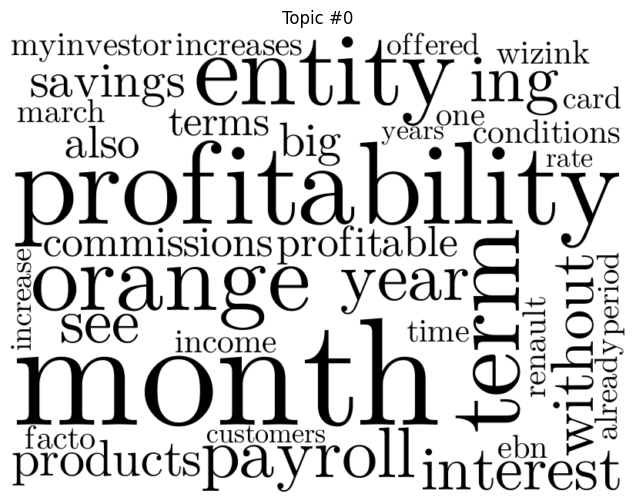

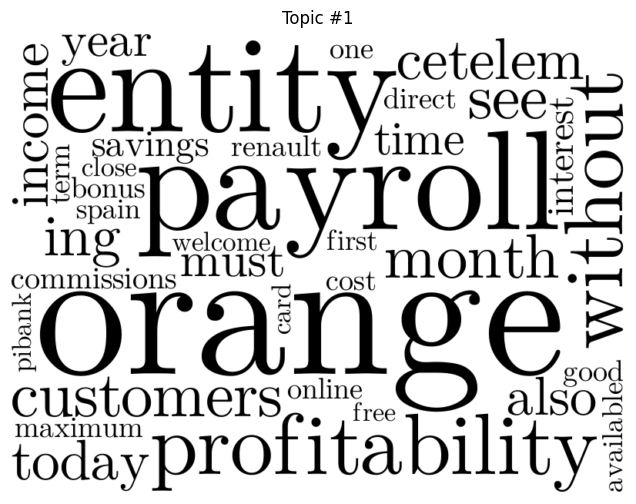

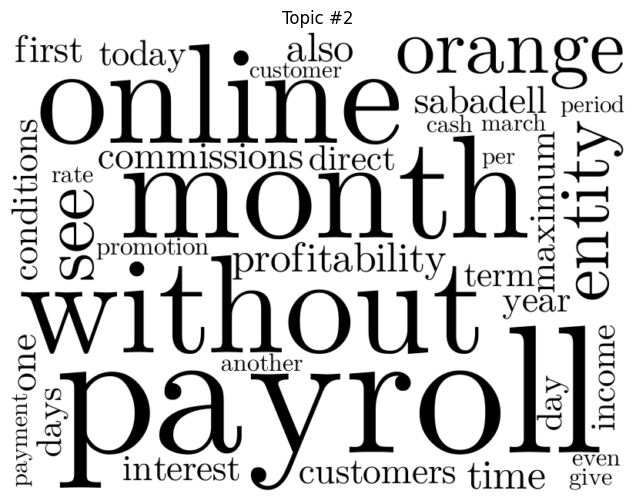

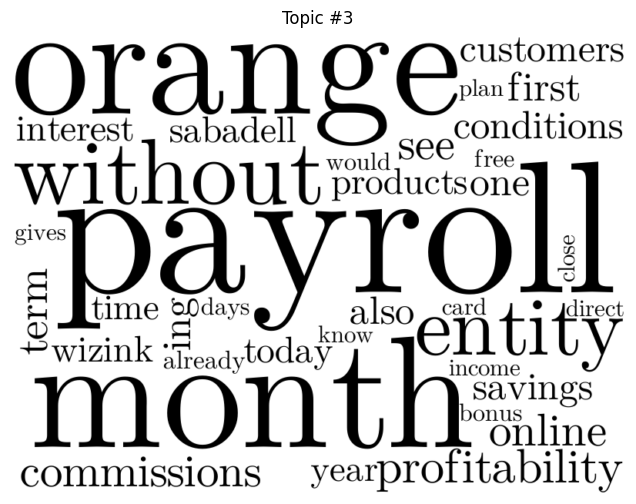

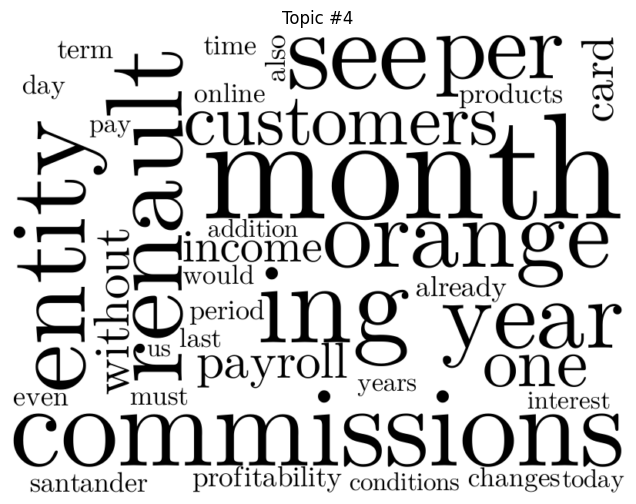

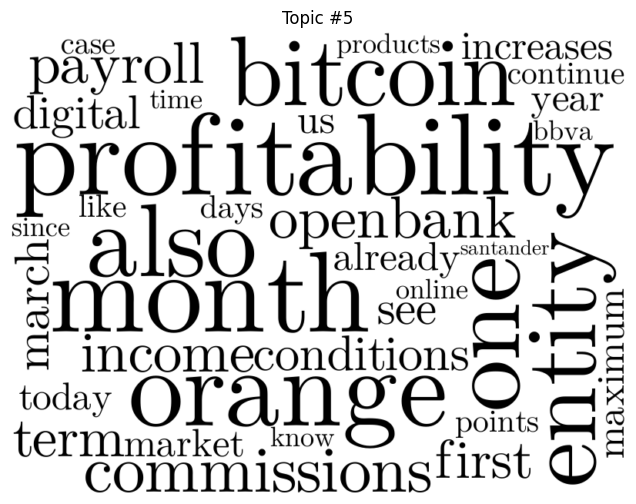

In [47]:
from wordcloud import WordCloud
import emojis
import matplotlib.pyplot as plt

# Define a font path that supports emojis
font_path = 'D:/Hangze Wu/BSE/DSDM/semester3/Master Thesis/github_thesis/deloitte_digital_banking/tucapital_scraper/emoj_Symbola/Symbola.otf'

def generate_wordclouds(topics, dictionary, font_path, score_threshold=0.00001):
    excluded_words = {"bank", "banks", "apr", "client", "clients", "account", "accounts",
                      "deposit", "deposits", "banco", "new", "months", "offer", "offers", "money"}

    for topic_num, topic_words in topics:
        # Remove excluded words and apply score threshold
        filtered_topic_words = [(word, freq) for word, freq in topic_words if word.lower() not in excluded_words and freq >= score_threshold]

        word_freq = dict(filtered_topic_words)
        wordcloud = WordCloud(
            width=800,
            height=600,
            background_color='white',
            color_func=lambda *args, **kwargs: "black",  # Default color for non-emojis
            font_path=font_path,  # Specify emoji support
            min_font_size=10,
            regexp=r"\S+",  # Regular expression to include all non-whitespace characters
        ).generate_from_frequencies(word_freq)
        
        # Define a custom color function for emojis
        def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
            if word in emojis.UNICODE_EMOJI:  # Check if the word is an emoji
                return "lightblue"  # Set color for emojis
            else:
                return "black"  # Default color for non-emojis
        
        # Apply the custom color function
        wordcloud.color_func = color_func
        
        plt.figure(figsize=(8, 6), facecolor=None)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f'Topic #{topic_num}')
        plt.show()

# Generate word clouds for each topic
generate_wordclouds(topics, lda_model.id2word, font_path, score_threshold=0.001)


In [48]:
df_copy.head(5)

,title,url,date,text,combined_text,word_count,year,topic_scores,dominant_topic,month_year
0,"Tomorrow, last day of the account at 2.89% APR...",https://www.tucapital.es/depositos/manana-ulti...,2024-04-23,"Tomorrow, April 24, 2024, the marketing period...",tomorrow last day account apr deposit apr rena...,318,2024,"[(0, 0.12626715), (1, 0.001080124), (2, 0.0010...",4,2024-04
1,ING gives you up to €120 if you direct your pa...,https://www.tucapital.es/cuentas/ing-te-da-has...,2024-04-22,"ING now asks, in addition to direct debiting a...",ing gives direct payroll pay card ing gives di...,400,2024,"[(0, 0.047485646), (1, 0.942512), (2, 0.001001...",1,2024-04
2,Banco BIG deposits: slight increase in normal ...,https://www.tucapital.es/depositos/depositos-d...,2024-04-22,Banco BIG remodels its deposit offer with slig...,banco big deposits slight increase normal comb...,476,2024,"[(0, 0.99649715), (1, 0.0007009482), (2, 0.000...",0,2024-04
3,The future of Bitcoin: predictions for the nex...,https://www.tucapital.es/blogs/guias/el-futuro...,2024-04-22,"Since its launch, Bitcoin has seen positive an...",future bitcoin predictions next years future b...,656,2024,"[(0, 0.0004339847), (1, 0.0004342081), (2, 0.0...",5,2024-04
4,Eco: Cetelem only allows maximum daily transfe...,https://www.tucapital.es/blogs/eco/eco-cetelem...,2024-04-19,"Due to the disappearance of Orange Bank, and t...",eco cetelem allows maximum daily transfers eco...,450,2024,"[(0, 0.00077776366), (1, 0.9961053), (2, 0.000...",1,2024-04


In [49]:
file_path = 'D:/Hangze Wu/BSE/DSDM/semester3/Master Thesis/thesis project/data/Account Products.xlsx'
bank_df = pd.read_excel(file_path, sheet_name='account_products')

bank_df.head(5)

,Unnamed: 0,account product,bank,url - bank product information
0,1,Cuenta N26,N26,n26.com/es-es/cuenta-sin-comisiones
1,2,Cuenta Online Sabadell,Banc Sabadell,bancsabadell.com/cuenta-online
2,3,Cuenta Clara Abanca,ABANCA,abanca.com/es/cuentas/cuenta-online
3,4,Cuenta Inteligente Bienvenida Evo,EVO Banco,evobanco.com/cuenta-inteligente/
4,5,Cuenta No Cuenta,ING,ing.es/cuenta-nocuenta-ing


In [50]:
file_path = 'D:/Hangze Wu/BSE/DSDM/semester3/Master Thesis/thesis project/data/Account Products_VF.xlsx'
bank_df = pd.read_excel(file_path, sheet_name='bank & accounts',skiprows=2)

bank_df.rename(columns={'url' : 'url - bank product information','account':'account product'}, inplace=True)
bank_df.head(5)

,Unnamed: 0,bank,account product,url - bank product information
0,1.0,abanca.com,Cuenta Online Clara,abanca.com/es/cuentas/cuenta-online
1,2.0,bancosantander.es,Cuenta Online Santander,bancosantander.es/particulares/cuentas-tarjeta...
2,3.0,bancsabadell.com,Cuenta Online Sabadell,bancsabadell.com/cuenta-online
3,4.0,bankinter.com,Cuenta Nómina Bankinter,bankinter.com/banca/cuentas-tarjetas/cuentas/c...
4,5.0,bbva.es,Cuenta Online Sin Comisiones,bbva.es/personas/productos/cuentas/cuenta-onli...


In [51]:
# Convert 'Account Product' in bank_df to lowercase
bank_df['account product'] = bank_df['account product'].str.lower()

merged_df = bank_df
merged_df['account product'].nunique()

13

In [52]:
cleaned_df = merged_df.dropna(subset=['account product'])

In [55]:
cleaned_df.rename(columns={'url - bank product information' : 'URL'}, inplace=True)

file_path = 'D:/Hangze Wu/BSE/DSDM/semester3/Master Thesis/thesis project/data/Account Products_VF.xlsx'
web_traffic_df = pd.read_excel(file_path, sheet_name='Accounts Traffic (Desktop)', skiprows = 3)
web_traffic_df.head(5)

,Date,abanca.com/es/cuentas/cuenta-online,bancosantander.es/particulares/cuentas-tarjetas/cuentas-corrientes/cuenta-online-sin-comisiones,bancsabadell.com/cuenta-online,bankinter.com/banca/cuentas-tarjetas/cuentas/cuenta-nomina,bbva.es/personas/productos/cuentas/cuenta-online-sin-comisiones.html,caixabank.es/particular/cuentas/cuenta-sin-comisiones.html,evobanco.com/cuenta-inteligente,ing.es/cuenta-nomina-ing,ing.es/cuenta-nocuenta-ing,myinvestor.es/cuentas-tarjetas/cuentas,n26.com/es-es/cuenta-ahorro,n26.com/es-es/cuenta-sin-comisiones,openbank.es/cuenta-ahorro-bienvenida,revolut.com/es-ES/a-radically-better-account/
0,2021-12-01,15202.983835,22325.885971,NaN,8733.560835,45449.486787,NaN,5055.542564,84404.564991,NaN,5319.608623,NaN,6664.368911,NaN,1343.418328
1,2022-01-01,42183.913207,28331.245044,NaN,11410.593443,38306.464983,NaN,4539.012047,110783.295080,NaN,6577.851993,NaN,5310.177360,NaN,1531.016801
2,2022-02-01,34498.153115,23798.819170,NaN,8891.661053,40978.325821,NaN,6049.457905,79688.098029,NaN,4031.716960,NaN,5547.588971,NaN,1304.591257
3,2022-03-01,34546.319021,24808.561729,NaN,7446.925144,43970.545627,NaN,9826.193608,80021.161861,NaN,4941.009311,NaN,4900.271300,NaN,1105.180575
4,2022-04-01,40508.288420,24739.758729,NaN,10285.861726,40782.451956,NaN,5028.236254,74071.446350,NaN,5774.734455,NaN,4909.581023,NaN,1020.968713


In [56]:
web_traffic_df = web_traffic_df.reset_index(drop=True)
# Melting the DataFrame
long_web_traffic_df = web_traffic_df.melt(id_vars=['Date'], var_name='URL', value_name='Web Traffic')


# Ensure no 'index' labels incorrectly positioned
print(long_web_traffic_df.head(5)), long_web_traffic_df['URL'].nunique()

        Date                                  URL   Web Traffic
0 2021-12-01  abanca.com/es/cuentas/cuenta-online  15202.983835
1 2022-01-01  abanca.com/es/cuentas/cuenta-online  42183.913207
2 2022-02-01  abanca.com/es/cuentas/cuenta-online  34498.153115
3 2022-03-01  abanca.com/es/cuentas/cuenta-online  34546.319021
4 2022-04-01  abanca.com/es/cuentas/cuenta-online  40508.288420


(None, 14)

In [57]:
long_web_traffic_df['Date'] = pd.to_datetime(long_web_traffic_df['Date'])

web_traffic_merged_df = pd.merge(
    cleaned_df, 
    long_web_traffic_df, 
    how='left', 
    on=['URL']
)

In [58]:
# Drop unnecessary columns
specific_category_df = web_traffic_merged_df.drop(columns=['Unnamed: 0', 'URL'])
specific_category_df.head(5)

,bank,account product,Date,Web Traffic
0,abanca.com,cuenta online clara,2021-12-01,15202.983835
1,abanca.com,cuenta online clara,2022-01-01,42183.913207
2,abanca.com,cuenta online clara,2022-02-01,34498.153115
3,abanca.com,cuenta online clara,2022-03-01,34546.319021
4,abanca.com,cuenta online clara,2022-04-01,40508.288420


In [59]:
df_copy.head(5)

,title,url,date,text,combined_text,word_count,year,topic_scores,dominant_topic,month_year
0,"Tomorrow, last day of the account at 2.89% APR...",https://www.tucapital.es/depositos/manana-ulti...,2024-04-23,"Tomorrow, April 24, 2024, the marketing period...",tomorrow last day account apr deposit apr rena...,318,2024,"[(0, 0.12626715), (1, 0.001080124), (2, 0.0010...",4,2024-04
1,ING gives you up to €120 if you direct your pa...,https://www.tucapital.es/cuentas/ing-te-da-has...,2024-04-22,"ING now asks, in addition to direct debiting a...",ing gives direct payroll pay card ing gives di...,400,2024,"[(0, 0.047485646), (1, 0.942512), (2, 0.001001...",1,2024-04
2,Banco BIG deposits: slight increase in normal ...,https://www.tucapital.es/depositos/depositos-d...,2024-04-22,Banco BIG remodels its deposit offer with slig...,banco big deposits slight increase normal comb...,476,2024,"[(0, 0.99649715), (1, 0.0007009482), (2, 0.000...",0,2024-04
3,The future of Bitcoin: predictions for the nex...,https://www.tucapital.es/blogs/guias/el-futuro...,2024-04-22,"Since its launch, Bitcoin has seen positive an...",future bitcoin predictions next years future b...,656,2024,"[(0, 0.0004339847), (1, 0.0004342081), (2, 0.0...",5,2024-04
4,Eco: Cetelem only allows maximum daily transfe...,https://www.tucapital.es/blogs/eco/eco-cetelem...,2024-04-19,"Due to the disappearance of Orange Bank, and t...",eco cetelem allows maximum daily transfers eco...,450,2024,"[(0, 0.00077776366), (1, 0.9961053), (2, 0.000...",1,2024-04


### Merge Article data with Web Traffic data ----- Prepararing for model

In [60]:
from collections import defaultdict

# Ensure 'date' is in datetime format and extract 'month_year'
df_copy['date'] = pd.to_datetime(df_copy['date'])
df_copy['month_year'] = df_copy['date'].dt.to_period('M').astype(str)

# Initialize a dictionary to hold the sum of topic scores for each month and account product
topic_scores_by_month = defaultdict(lambda: defaultdict(float))

# Sum the topic scores for each document by month_year
for i, row in df_copy.iterrows():
    month_year = row['month_year']
    for topic, score in row['topic_scores']:
        topic_scores_by_month[month_year][topic] += score

# Convert the dictionary to a DataFrame for easier analysis and visualization
topic_scores_df = pd.DataFrame(topic_scores_by_month).T.reset_index()
topic_scores_df.columns = ['month_year'] + [f'topic_{i}' for i in range(len(topic_scores_df.columns) - 1)]

# Display the topic scores by month
display(topic_scores_df.head(3))

,month_year,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5
0,2024-04,8.646887,11.748401,2.076855,0.751315,4.043099,1.733443
1,2024-03,7.977824,8.164131,2.559730,3.857079,5.263551,0.177684
2,2024-02,22.655673,9.989678,3.433644,0.535299,2.688225,1.697480


In [61]:
# Convert the 'Date' column in specific_category_df to period format for merging
specific_category_df['month_year'] = pd.to_datetime(specific_category_df['Date']).dt.to_period('M').astype(str)

# Merge the web traffic data with the aggregated topic scores data
merged_df = pd.merge(specific_category_df, topic_scores_df, on='month_year', how='left')

# Drop unnecessary columns
merged_df.drop(columns=['Date'], inplace=True)

# Display the first few rows of the merged dataframe
display(merged_df.head(3)),merged_df['Web Traffic'].isnull().count()

,bank,account product,Web Traffic,month_year,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5
0,abanca.com,cuenta online clara,15202.983835,2021-12,3.337507,4.623250,3.695718,3.085761,2.165576,0.092187
1,abanca.com,cuenta online clara,42183.913207,2022-01,2.683793,6.798754,2.499575,2.012523,3.373025,1.632329
2,abanca.com,cuenta online clara,34498.153115,2022-02,3.743583,4.827289,1.871747,4.630937,1.913939,0.012506


(None, 378)

In [62]:
merged_df.dropna(subset=['Web Traffic'], inplace=True)

In [63]:
print("Number of NaNs in 'Web Traffic':", merged_df['Web Traffic'].isna().sum())

Number of NaNs in 'Web Traffic': 0


In [64]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define features (topic scores) and target (web traffic)
X = merged_df.drop(columns=['Web Traffic', 'bank', 'account product', 'month_year'])
y = merged_df['Web Traffic']

print("Number of NaNs in features:", X.isna().sum().sum())
print("Number of NaNs in target:", y.isna().sum())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Feature importance
importance = rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print(feature_importance_df)


Number of NaNs in features: 0
Number of NaNs in target: 0
Mean Squared Error: 518199610.65231055
   Feature  Importance
0  topic_0    0.209665
1  topic_1    0.196221
5  topic_5    0.172130
2  topic_2    0.160918
4  topic_4    0.152587
3  topic_3    0.108479


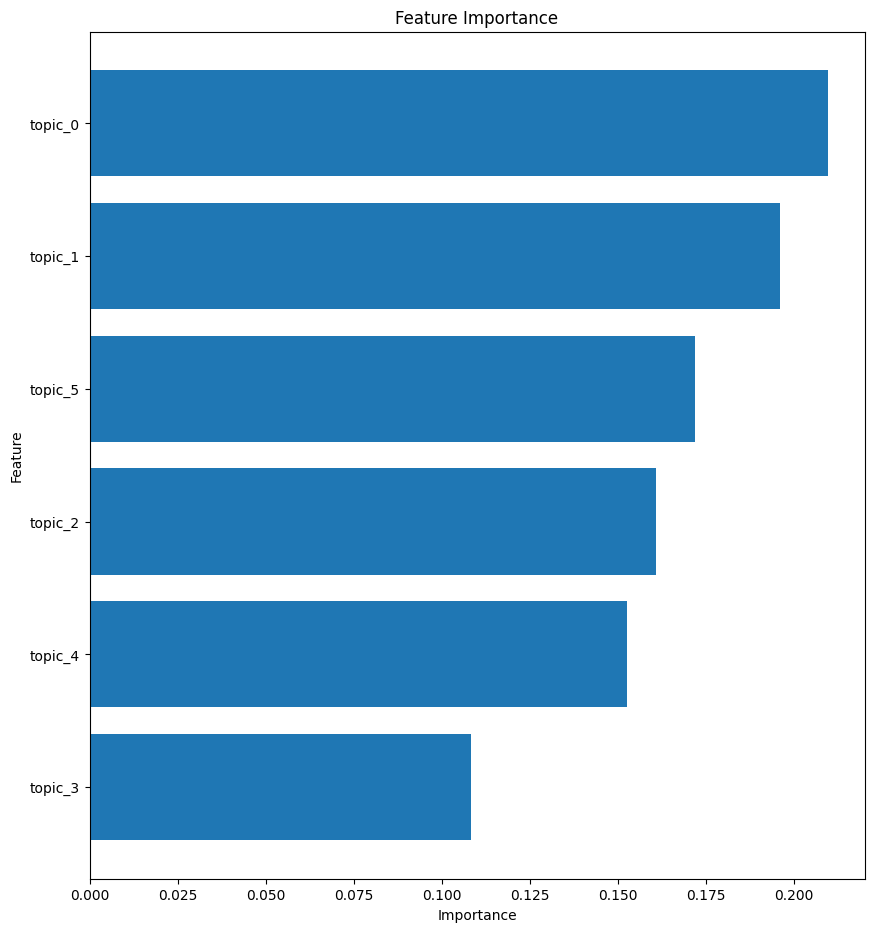

In [65]:
import matplotlib.pyplot as plt

# Plot feature importance
plt.figure(figsize=(10, 11))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()


In [66]:
from sklearn.model_selection import cross_val_score, GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest model
rf = RandomForestRegressor(random_state=42)

# Initialize the Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the Grid Search to the data
grid_search.fit(X_train, y_train)

# Best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

# Evaluate the best model
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Improved Mean Squared Error: {mse}')


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best Score: -0.2413215023319669
Improved Mean Squared Error: 511163943.10540545


R-squared: -0.14828558933949165
Mean Absolute Error: 19154.514089810687
Mean Squared Error: 511163943.10540545


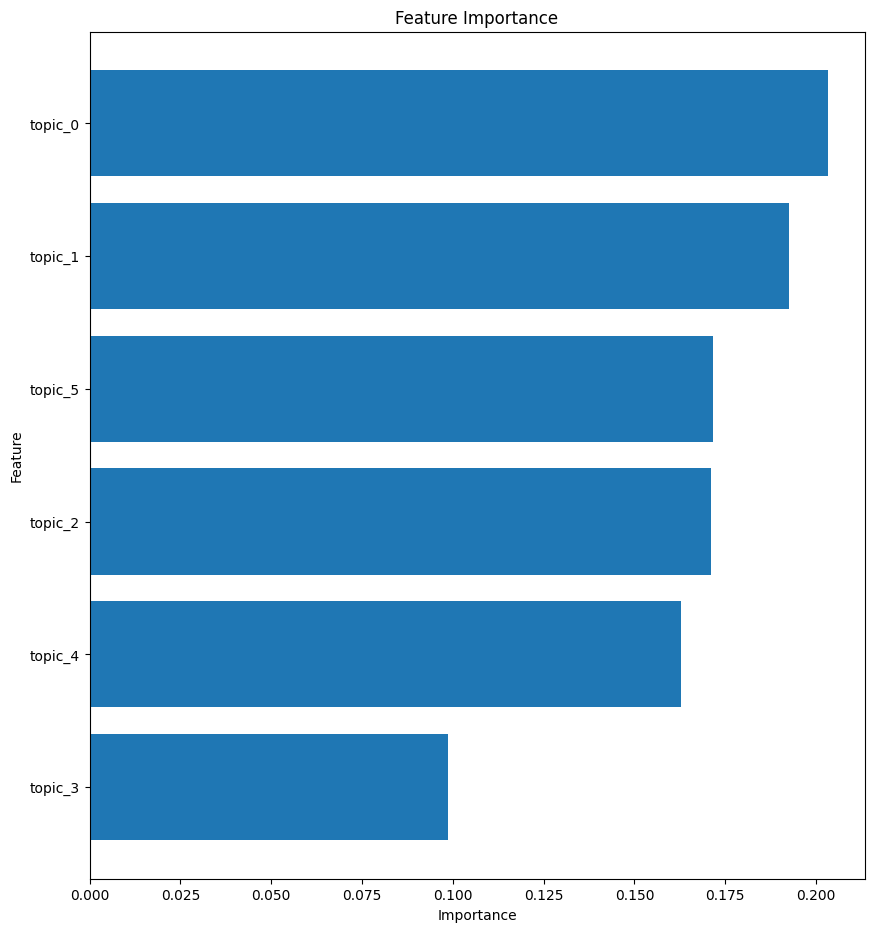

In [67]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate R-squared, Mean Absolute Error (MAE), and Mean Squared Error (MSE)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R-squared: {r2}')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')

# Plot feature importance
import matplotlib.pyplot as plt

# Feature importance
importance = best_rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 11))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

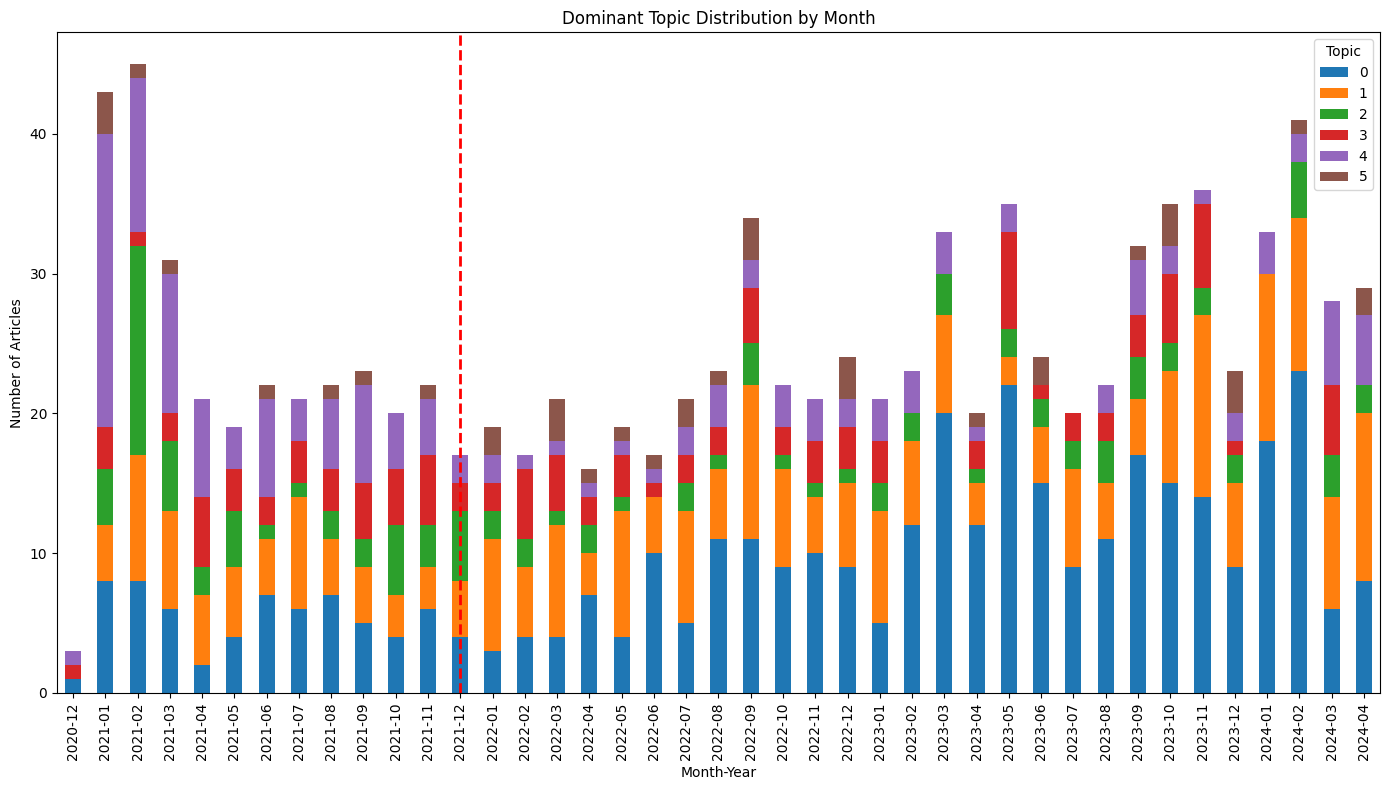

In [68]:
# Add a column for the dominant topic in each document
df_copy['dominant_topic'] = [max(doc, key=lambda x: x[1])[0] for doc in doc_topics]

# Group by month and dominant topic to see the distribution
dominant_topic_distribution = df_copy.groupby(['month_year', 'dominant_topic']).size().unstack(fill_value=0)

# Plot the dominant topic distribution by month
dominant_topic_distribution.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Dominant Topic Distribution by Month')
plt.xlabel('Month-Year')
plt.ylabel('Number of Articles')
plt.legend(title='Topic')
plt.axvline(x=dominant_topic_distribution.index.get_loc('2021-12'), color='red', linestyle='--', linewidth=2, label='Start of Web Traffic Data')
plt.tight_layout()
plt.show()


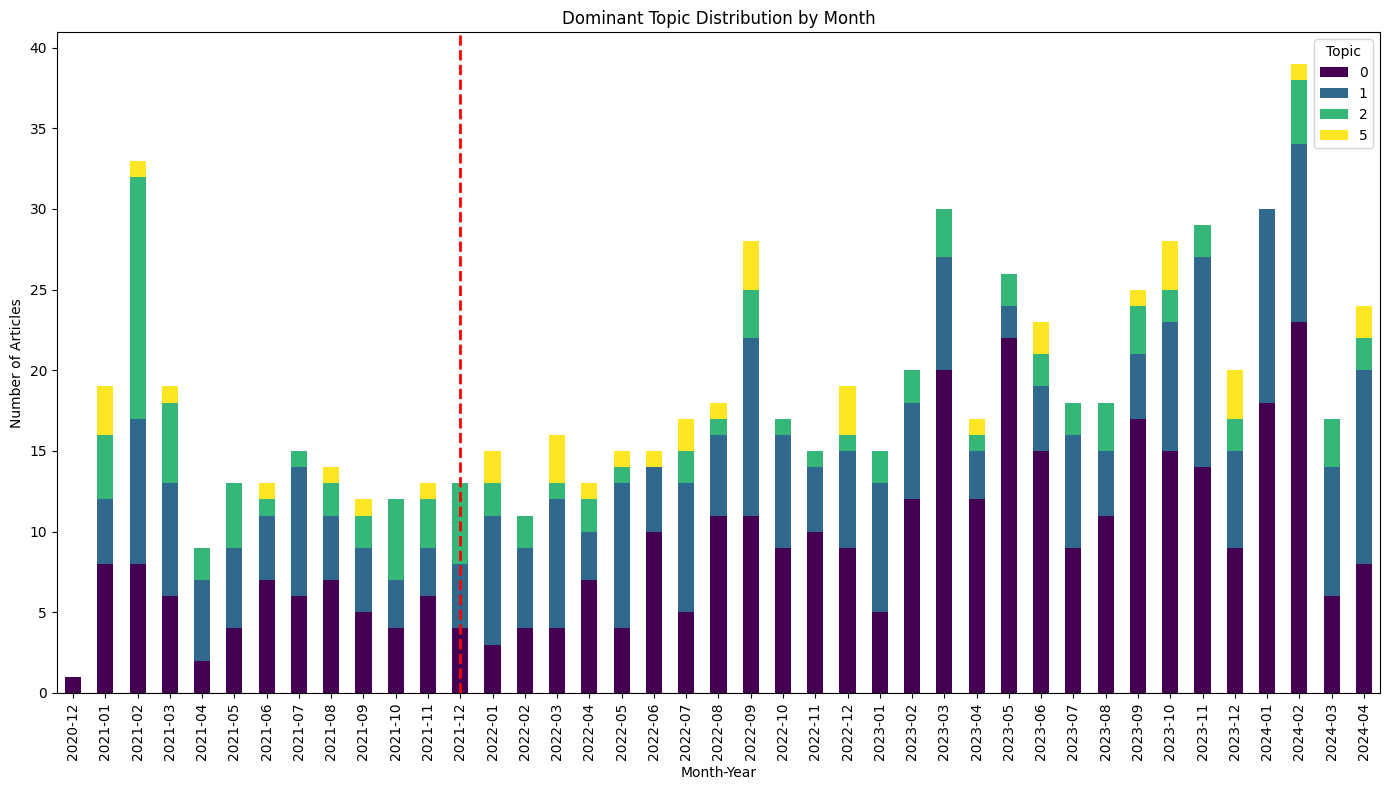

In [70]:
import matplotlib.pyplot as plt

# Add a column for the dominant topic in each document
df_copy['dominant_topic'] = [max(doc, key=lambda x: x[1])[0] for doc in doc_topics]

# Filter the DataFrame to include only the desired topics
desired_topics = [0, 1, 2, 5]
filtered_df_copy = df_copy[df_copy['dominant_topic'].isin(desired_topics)]

# Group by month and dominant topic to see the distribution
dominant_topic_distribution = filtered_df_copy.groupby(['month_year', 'dominant_topic']).size().unstack(fill_value=0)

# Plot the dominant topic distribution by month
dominant_topic_distribution.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='viridis')
plt.title('Dominant Topic Distribution by Month')
plt.xlabel('Month-Year')
plt.ylabel('Number of Articles')
plt.legend(title='Topic')
plt.axvline(x=dominant_topic_distribution.index.get_loc('2021-12'), color='red', linestyle='--', linewidth=2, label='Start of Web Traffic Data')
plt.tight_layout()
plt.show()


In [71]:
csv_file_path = 'D:/Hangze Wu/BSE/DSDM/semester3/Master Thesis/thesis project/data/df_copy.csv'

# Save the DataFrame to a CSV file
df_copy.to_csv(csv_file_path, index=False)

In [72]:
df_copy.columns

Index(['title', 'url', 'date', 'text', 'combined_text', 'word_count', 'year',
       'topic_scores', 'dominant_topic', 'month_year'],
      dtype='object')

In [74]:
from collections import defaultdict

# Ensure 'date' is in datetime format and extract 'month_year'
df_copy['date'] = pd.to_datetime(df_copy['date'])
df_copy['month_year'] = df_copy['date'].dt.to_period('M').astype(str)

# Initialize a dictionary to hold the sum of topic scores for each month
topic_scores_by_month = defaultdict(lambda: defaultdict(float))

# Sum the topic scores for each document by month_year
for i, row in df_copy.iterrows():
    month_year = row['month_year']
    for topic, score in row['topic_scores']:
        topic_scores_by_month[month_year][topic] += score

# Convert the dictionary to a DataFrame for easier analysis and visualization
topic_scores_df = pd.DataFrame(topic_scores_by_month).T.reset_index()

# Set the column names correctly (adjusting for the actual number of topics)
num_topics = len(topic_scores_df.columns) - 1
column_names = ['month_year'] + [f'topic_{i}' for i in range(num_topics)]
topic_scores_df.columns = column_names

# Keep only the desired topics
desired_topics = ['month_year', 'topic_0', 'topic_1', 'topic_2','topic_5','topic_3','topic_4']
topic_scores_df = topic_scores_df[desired_topics]

# Merge the desired columns from df_copy with the topic scores DataFrame
df_copy_filtered = df_copy[['title', 'url', 'date', 'combined_text', 'text', 'month_year', 'dominant_topic','topic_scores']]
merged_df = pd.merge(df_copy_filtered, topic_scores_df, on='month_year', how='left')

In [77]:
df_copy_filtered

,title,url,date,combined_text,text,month_year,dominant_topic,topic_scores
0,"Tomorrow, last day of the account at 2.89% APR...",https://www.tucapital.es/depositos/manana-ulti...,2024-04-23,tomorrow last day account apr deposit apr rena...,"Tomorrow, April 24, 2024, the marketing period...",2024-04,4,"[(0, 0.12626715), (1, 0.001080124), (2, 0.0010..."
1,ING gives you up to €120 if you direct your pa...,https://www.tucapital.es/cuentas/ing-te-da-has...,2024-04-22,ing gives direct payroll pay card ing gives di...,"ING now asks, in addition to direct debiting a...",2024-04,1,"[(0, 0.047485646), (1, 0.942512), (2, 0.001001..."
2,Banco BIG deposits: slight increase in normal ...,https://www.tucapital.es/depositos/depositos-d...,2024-04-22,banco big deposits slight increase normal comb...,Banco BIG remodels its deposit offer with slig...,2024-04,0,"[(0, 0.99649715), (1, 0.0007009482), (2, 0.000..."
3,The future of Bitcoin: predictions for the nex...,https://www.tucapital.es/blogs/guias/el-futuro...,2024-04-22,future bitcoin predictions next years future b...,"Since its launch, Bitcoin has seen positive an...",2024-04,5,"[(0, 0.0004339847), (1, 0.0004342081), (2, 0.0..."
4,Eco: Cetelem only allows maximum daily transfe...,https://www.tucapital.es/blogs/eco/eco-cetelem...,2024-04-19,eco cetelem allows maximum daily transfers eco...,"Due to the disappearance of Orange Bank, and t...",2024-04,1,"[(0, 0.00077776366), (1, 0.9961053), (2, 0.000..."
...,...,...,...,...,...,...,...,...
1013,Pibank and Pichincha maintain your deposit at ...,https://www.tucapital.es/cuentas/pibank-y-pich...,2021-01-04,pibank pichincha maintain deposit apr january ...,"Pibank, the online office of Banco Pichincha, ...",2021-01,0,"[(0, 0.56253207), (1, 0.4239125), (2, 0.000805..."
1014,"New year, new taxes. This is how the Treasury ...",https://www.tucapital.es/blogs/noticias/ano-nu...,2021-01-04,new year new taxes treasury reach pockets new ...,I wish that with this first post of the year w...,2021-01,0,"[(0, 0.56087863), (1, 0.32747966), (2, 0.00071..."
1015,"Big Bank, RenaultBank...and OrangeBank?, new a...",https://www.tucapital.es/cuentas/banco-big-ren...,2020-12-31,big bank renaultbank orangebank new profitable...,"As we told you yesterday (see here), 2020 has ...",2020-12,0,"[(0, 0.99364495), (1, 0.0033220744), (2, 0.000..."
1016,"Goodbye 2020, black year of banking fees. News...",https://www.tucapital.es/blogs/noticias/adios-...,2020-12-30,goodbye black year banking fees news summary g...,2020 has been a black year. It has been the ye...,2020-12,4,"[(0, 0.0005046447), (1, 0.00050493533), (2, 0...."


In [76]:
df_copy

,title,url,date,text,combined_text,word_count,year,topic_scores,dominant_topic,month_year
0,"Tomorrow, last day of the account at 2.89% APR...",https://www.tucapital.es/depositos/manana-ulti...,2024-04-23,"Tomorrow, April 24, 2024, the marketing period...",tomorrow last day account apr deposit apr rena...,318,2024,"[(0, 0.12626715), (1, 0.001080124), (2, 0.0010...",4,2024-04
1,ING gives you up to €120 if you direct your pa...,https://www.tucapital.es/cuentas/ing-te-da-has...,2024-04-22,"ING now asks, in addition to direct debiting a...",ing gives direct payroll pay card ing gives di...,400,2024,"[(0, 0.047485646), (1, 0.942512), (2, 0.001001...",1,2024-04
2,Banco BIG deposits: slight increase in normal ...,https://www.tucapital.es/depositos/depositos-d...,2024-04-22,Banco BIG remodels its deposit offer with slig...,banco big deposits slight increase normal comb...,476,2024,"[(0, 0.99649715), (1, 0.0007009482), (2, 0.000...",0,2024-04
3,The future of Bitcoin: predictions for the nex...,https://www.tucapital.es/blogs/guias/el-futuro...,2024-04-22,"Since its launch, Bitcoin has seen positive an...",future bitcoin predictions next years future b...,656,2024,"[(0, 0.0004339847), (1, 0.0004342081), (2, 0.0...",5,2024-04
4,Eco: Cetelem only allows maximum daily transfe...,https://www.tucapital.es/blogs/eco/eco-cetelem...,2024-04-19,"Due to the disappearance of Orange Bank, and t...",eco cetelem allows maximum daily transfers eco...,450,2024,"[(0, 0.00077776366), (1, 0.9961053), (2, 0.000...",1,2024-04
...,...,...,...,...,...,...,...,...,...,...
1013,Pibank and Pichincha maintain your deposit at ...,https://www.tucapital.es/cuentas/pibank-y-pich...,2021-01-04,"Pibank, the online office of Banco Pichincha, ...",pibank pichincha maintain deposit apr january ...,426,2021,"[(0, 0.56253207), (1, 0.4239125), (2, 0.000805...",0,2021-01
1014,"New year, new taxes. This is how the Treasury ...",https://www.tucapital.es/blogs/noticias/ano-nu...,2021-01-04,I wish that with this first post of the year w...,new year new taxes treasury reach pockets new ...,572,2021,"[(0, 0.56087863), (1, 0.32747966), (2, 0.00071...",0,2021-01
1015,"Big Bank, RenaultBank...and OrangeBank?, new a...",https://www.tucapital.es/cuentas/banco-big-ren...,2020-12-31,"As we told you yesterday (see here), 2020 has ...",big bank renaultbank orangebank new profitable...,443,2020,"[(0, 0.99364495), (1, 0.0033220744), (2, 0.000...",0,2020-12
1016,"Goodbye 2020, black year of banking fees. News...",https://www.tucapital.es/blogs/noticias/adios-...,2020-12-30,2020 has been a black year. It has been the ye...,goodbye black year banking fees news summary g...,733,2020,"[(0, 0.0005046447), (1, 0.00050493533), (2, 0....",4,2020-12


In [75]:
# Save the DataFrame to a CSV file
csv_file_path = 'D:/Hangze Wu/BSE/DSDM/semester3/Master Thesis/thesis project/data/df_copy_filtered.csv'
merged_df.to_csv(csv_file_path, index=False)

print(f'DataFrame saved to {csv_file_path}')

DataFrame saved to D:/Hangze Wu/BSE/DSDM/semester3/Master Thesis/thesis project/data/df_copy_filtered.csv


#### Regression

In [107]:
# Load the regression_clean_data.csv file
regression_clean_data_path = f"D:\Hangze Wu\BSE\DSDM\semester3\Master Thesis\github_thesis\deloitte_digital_banking\deloitte_digital_banking\data\\final_regression_data.csv"
regression_clean_data = pd.read_csv(regression_clean_data_path)

# Convert the date column to datetime format
regression_clean_data['date'] = pd.to_datetime(regression_clean_data['date'])

# Create the month_year column as period type
regression_clean_data['month_year'] = regression_clean_data['date'].dt.to_period('M')

# Display the first few rows of the loaded data
display(regression_clean_data.head(3))
display(df_copy_filtered.head(3))

,bank,date,web_traffic,number_of_employee,assets_under_management,number_of_branches,age,has_stores,founded_before_2000,cross_visitation,search_interest,rank,category_best_salary_accounts_helmycash,category_best_savings_accounts_helpmycash,incentive,apr,mentions,month_year
0,abanca,2021-12-01,15202.983835,5946,72148000000,690,13,1,0,0.077994,17.652686,4.0,0,0,150.0,0.0,1.0,2021-12
1,abanca,2021-12-01,15202.983835,5946,72148000000,690,13,1,0,0.077994,17.652686,4.0,1,0,150.0,0.0,1.0,2021-12
2,abanca,2021-12-01,15202.983835,5946,72148000000,690,13,1,0,0.077994,17.652686,4.0,0,1,150.0,0.0,1.0,2021-12


,title,url,date,combined_text,text,month_year,dominant_topic,topic_scores
0,"Tomorrow, last day of the account at 2.89% APR...",https://www.tucapital.es/depositos/manana-ulti...,2024-04-23,tomorrow last day account apr deposit apr rena...,"Tomorrow, April 24, 2024, the marketing period...",2024-04,4,"[(0, 0.12626715), (1, 0.001080124), (2, 0.0010..."
1,ING gives you up to €120 if you direct your pa...,https://www.tucapital.es/cuentas/ing-te-da-has...,2024-04-22,ing gives direct payroll pay card ing gives di...,"ING now asks, in addition to direct debiting a...",2024-04,1,"[(0, 0.047485646), (1, 0.942512), (2, 0.001001..."
2,Banco BIG deposits: slight increase in normal ...,https://www.tucapital.es/depositos/depositos-d...,2024-04-22,banco big deposits slight increase normal comb...,Banco BIG remodels its deposit offer with slig...,2024-04,0,"[(0, 0.99649715), (1, 0.0007009482), (2, 0.000..."


In [108]:
df_copy_filtered['date'] = pd.to_datetime(df_copy_filtered['date'])
df_copy_filtered['month_year'] = df_copy_filtered['date'].dt.to_period('M')

# Create columns for each topic (0 to 5) indicating the monthly counts
topic_counts = df_copy_filtered.pivot_table(index='month_year', columns='dominant_topic', aggfunc='size', fill_value=0)

# Rename columns to indicate topic count
topic_counts.columns = [f'topic_{int(col)}_count' for col in topic_counts.columns]

# Reset index to merge with the regression_clean_data
topic_counts = topic_counts.reset_index()

# Ensure 'month_year' column exists and is in period format in both dataframes
print(regression_clean_data.columns)
print(topic_counts.columns)

# Merge the topic counts with the regression_clean_data
merged_data = pd.merge(regression_clean_data, topic_counts, how='left', left_on='month_year', right_on='month_year')

# Display the merged data
display(merged_data.head(10))


Index(['bank', 'date', 'web_traffic', 'number_of_employee',
       'assets_under_management', 'number_of_branches', 'age', 'has_stores',
       'founded_before_2000', 'cross_visitation', 'search_interest', 'rank',
       'category_best_salary_accounts_helmycash',
       'category_best_savings_accounts_helpmycash', 'incentive', 'apr',
       'mentions', 'month_year'],
      dtype='object')
Index(['month_year', 'topic_0_count', 'topic_1_count', 'topic_2_count',
       'topic_3_count', 'topic_4_count', 'topic_5_count'],
      dtype='object')


,bank,date,web_traffic,number_of_employee,assets_under_management,number_of_branches,age,has_stores,founded_before_2000,cross_visitation,...,incentive,apr,mentions,month_year,topic_0_count,topic_1_count,topic_2_count,topic_3_count,topic_4_count,topic_5_count
0,abanca,2021-12-01,15202.983835,5946,72148000000,690,13,1,0,0.077994,...,150.0,0.0,1.0,2021-12,4,4,5,2,2,0
1,abanca,2021-12-01,15202.983835,5946,72148000000,690,13,1,0,0.077994,...,150.0,0.0,1.0,2021-12,4,4,5,2,2,0
2,abanca,2021-12-01,15202.983835,5946,72148000000,690,13,1,0,0.077994,...,150.0,0.0,1.0,2021-12,4,4,5,2,2,0
3,abanca,2022-01-01,42183.913207,5946,72148000000,690,13,1,0,0.062500,...,150.0,0.0,1.0,2022-01,3,8,2,2,2,2
4,abanca,2022-01-01,42183.913207,5946,72148000000,690,13,1,0,0.062500,...,150.0,0.0,1.0,2022-01,3,8,2,2,2,2
5,abanca,2022-01-01,42183.913207,5946,72148000000,690,13,1,0,0.062500,...,150.0,0.0,1.0,2022-01,3,8,2,2,2,2
6,abanca,2022-02-01,34498.153115,5946,72148000000,690,13,1,0,0.052288,...,150.0,0.0,2.0,2022-02,4,5,2,5,1,0
7,abanca,2022-02-01,34498.153115,5946,72148000000,690,13,1,0,0.052288,...,150.0,0.0,2.0,2022-02,4,5,2,5,1,0
8,abanca,2022-02-01,34498.153115,5946,72148000000,690,13,1,0,0.052288,...,150.0,0.0,2.0,2022-02,4,5,2,5,1,0
9,abanca,2022-03-01,34546.319021,5946,72148000000,690,13,1,0,0.061503,...,150.0,0.0,2.0,2022-03,4,8,1,4,1,3


In [116]:
ind_vars = ['cross_visitation', 'rank', 'incentive', 'apr',
       'mentions', 'search_interest']

topics_vars = ['topic_0_count', 'topic_1_count' , 'topic_2_count' , 'topic_3_count' , 'topic_4_count', 'topic_5_count']

In [117]:
data = merged_data
# Ensure the relevant columns are numeric
data[ind_vars] = data[ind_vars].apply(pd.to_numeric, errors='coerce')
data['web_traffic'] = pd.to_numeric(data['web_traffic'], errors='coerce')

data.isna().sum()

bank                                         0
date                                         0
web_traffic                                  0
number_of_employee                           0
assets_under_management                      0
number_of_branches                           0
age                                          0
has_stores                                   0
founded_before_2000                          0
cross_visitation                             0
search_interest                              0
rank                                         0
category_best_salary_accounts_helmycash      0
category_best_savings_accounts_helpmycash    0
incentive                                    0
apr                                          0
mentions                                     0
month_year                                   0
topic_0_count                                0
topic_1_count                                0
topic_2_count                                0
topic_3_count

In [122]:
import statsmodels.api as sm

ind_vars = ['cross_visitation', 'rank', 'incentive', 'apr',
       'mentions', 'search_interest'] + ['topic_0_count', 'topic_1_count' , 'topic_2_count' , 'topic_5_count']

for bank in data['bank'].unique():
    bank_data = data[data['bank'] == bank]
    X = bank_data[ind_vars]
    y = bank_data['web_traffic']
    X = sm.add_constant(X)  # Add a constant term for the intercept
    model = sm.OLS(y, X)
    results = model.fit()
    print(f"Results for bank: {bank}")
    print(results.summary2())

Results for bank: abanca
                         Results: Ordinary least squares
Model:                    OLS                  Adj. R-squared:         0.611     
Dependent Variable:       web_traffic          AIC:                    1611.7405 
Date:                     2024-06-17 05:48     BIC:                    1637.2328 
No. Observations:         75                   Log-Likelihood:         -794.87   
Df Model:                 10                   F-statistic:            12.62     
Df Residuals:             64                   Prob (F-statistic):     8.89e-12  
R-squared:                0.663                Scale:                  1.1014e+08
---------------------------------------------------------------------------------
                    Coef.       Std.Err.     t    P>|t|     [0.025       0.975]  
---------------------------------------------------------------------------------
const              10337.1358  17513.6792  0.5902 0.5571  -24650.4605  45324.7320
cross_visitation

In [127]:
import plotly.graph_objects as go

# Assuming 'data' is your DataFrame and 'ind_vars' is a list of independent variable names.
for bank in data['bank'].unique():
    bank_data = data[data['bank'] == bank]
    fig = go.Figure()
    
    # Add web traffic trace
    fig.add_trace(go.Scatter(x=bank_data['date'], y=bank_data['web_traffic'], mode='lines', name='web_traffic', yaxis='y1'))
    
    # Add independent variables traces
    for ind_var in ind_vars:
        fig.add_trace(go.Scatter(x=bank_data['date'], y=bank_data[ind_var], mode='lines', name=ind_var, yaxis='y2'))
    
    # Update layout for secondary y-axis
    fig.update_layout(
        title=f"{bank} Web Traffic and Independent Variables",
        xaxis_title="Date",
        yaxis=dict(
            title="Web Traffic",
            titlefont=dict(color="#000000"),
            tickfont=dict(color="#000000")
        ),
        yaxis2=dict(
            title="Independent Variables",
            titlefont=dict(color="#000000"),
            tickfont=dict(color="#000000"),
            overlaying='y',
            side='right'
        )
        # move legend to the right so there is no overlap with the secondary y-axis
        ,legend=dict(x=1.1, y=1)
        
    )
    
    fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed